In [1]:
"""
*Filename: ProjectorTrainer
*Description: This jupyter notebook trains the DeepSetsMultivariateProjector architecture. It
*is the original copy of the first neural network model which converged to the bhadron targets
*successfully. Thus it acts as an archieve to ensure that if need a working version of the
*network can be referred back to. The primary reason this trainer worked over previous editions 
*is the addition of many more track and jet features which the network can use to regress.
Date: 16/02/2023
Author: Kaylen Smith Darnbrook
"""

# Import relevant modules
import os
import numpy as np
import seaborn as sns
import wandb
#from wandb.keras import WandbCallback
from keras import callbacks
import keras
import DeepSetNeuralNetArchitecture as DSNNA
from DeepSetNeuralNetArchitecture import LogNormal_Loss_Function
from DeepSetNeuralNetArchitecture import Mean_Squared_Error
from HffragDeepSetsProjectionMultivariate import DeepSetsProjection
from sklearn.feature_selection import mutual_info_regression
import keras.backend as k
import uproot
import awkward as ak
import sklearn as sk
from numpy.lib.recfunctions import structured_to_unstructured
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import pandas as pd
from hffrag import fixedbinning
from hffrag import binneddensity
from keras.utils.vis_utils import plot_model
from timeit import default_timer as timer
import matplotlib.pyplot as plt
%matplotlib inline

2023-02-13 14:26:37.478254: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-13 14:26:37.642939: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-13 14:26:37.647115: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-13 14:26:37.647132: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

number of jets to train on:
141329


/home/physics/phujdj/DeepLearningParticlePhysics/hffrag.py:136: RuntimeWarning: overflow encountered in sinh
  pzs = numpy.where(mask, pts, pts * numpy.sinh(etas))


In [2]:
#Format the style and format of the matplotlib plots
plt.style.use("default")
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rc('text',usetex = False)
plt.rc('font',family = 'Times New Roman')

In [3]:
# The data is being stored in a tree datastructure.
# We access the charm root using this command
tree = uproot.open("/storage/epp2/phswmv/data/hffrag/hffrag.root:CharmAnalysis")

In [4]:
# Initial parameters
MASKVAL = -999 # This value is introduced to ensure arrays are regular (Of the same size). They will be masked later by the network
MAXTRACKS = 32 # This value is the maximum number of tracks allowed per event
BATCHSIZE = 64 # This is the batch size of the mini batches used during training
EPOCHS = 1000# This is the default number of epochs for which the neural network will train providing that early stopping does not occur
MAXEVENTS = 2e5 #This is the maximum number of events that will the program will accept
LR = 5e-5 #This is the default learning rate

In [5]:
# Select the features we wish to study
track_features = ["AnalysisTracks_pt", "AnalysisTracks_eta", "AnalysisTracks_phi", "AnalysisTracks_z0sinTheta",
                  "AnalysisTracks_d0sig", "AnalysisTracks_d0", "AnalysisTracks_d0sigPV", "AnalysisTracks_d0PV"]
jet_features = ["AnalysisAntiKt4TruthJets_pt", "AnalysisAntiKt4TruthJets_eta", "AnalysisAntiKt4TruthJets_phi", "AnalysisAntiKt4TruthJets_m",
                "AnalysisAntiKt4TruthJets_ghostB_pt", "AnalysisAntiKt4TruthJets_ghostB_eta","AnalysisAntiKt4TruthJets_ghostB_phi", "AnalysisAntiKt4TruthJets_ghostB_m"]

In [6]:
# Read in the data from the root file
features = tree.arrays(jet_features+track_features, entry_stop=MAXEVENTS)

In [7]:
# Select the events of interest
events = features[ak.sum(
    features["AnalysisAntiKt4TruthJets_pt"] > 25000, axis=1) > 0]

In [8]:
# Displays the number of jets being trained on
jets = events[jet_features][:, 0]
print("The number of jets to train on is: ", len(jets))
print("The number of track features is: ",len(track_features))

The number of jets to train on is:  199840
The number of track features is:  8


In [9]:
# Select tracks from the events
tracks = events[track_features]

# Match the tracks to the jets
matchedtracks = tracks[DSNNA.Match_Tracks(jets, tracks)]

# Pad and Flatten the data
matchedtracks = DSNNA.flatten(matchedtracks, MAXTRACKS)

In [10]:
#Selects the b-jets with bhadrons with a transverse momentum over 5000 MeV
bjets = ak.sum(jets["AnalysisAntiKt4TruthJets_ghostB_pt"] > 5000, axis=1) > 0
jets = jets[bjets]

# Obtain the pt, eta and phi of each b hadron jet
bhads_pt = jets["AnalysisAntiKt4TruthJets_ghostB_pt"][:, 0].to_numpy()
bhads_eta = jets["AnalysisAntiKt4TruthJets_ghostB_eta"][:,0].to_numpy()
bhads_phi = jets["AnalysisAntiKt4TruthJets_ghostB_phi"][:,0].to_numpy()
bhads_m = jets["AnalysisAntiKt4TruthJets_ghostB_m"][:,0].to_numpy()

jets_pt = jets["AnalysisAntiKt4TruthJets_pt"].to_numpy()
jets_eta = jets["AnalysisAntiKt4TruthJets_eta"].to_numpy()
jets_phi = jets["AnalysisAntiKt4TruthJets_phi"].to_numpy()
jets_m = jets["AnalysisAntiKt4TruthJets_m"].to_numpy()
b_jets = np.stack([jets_pt,jets_eta,jets_phi, jets_m], axis = -1)

bhads = np.stack([bhads_pt,bhads_eta,bhads_phi, bhads_m],axis = -1) #Combine the momentum, eta and phi for each jet into one array

print("There are {} outputs".format(np.shape(bhads)[1])) # Display the number of target features the neural network will predict
matchedtracks = matchedtracks[bjets]
print("There are {} inputs".format(np.shape(matchedtracks)[1])) # Display the number of target features the neural network will use in it's predictions

There are 4 outputs
There are 32 inputs


In [11]:
# Transform the jet and tracks to unstructed data.
jets = structured_to_unstructured(jets[jet_features[:-4]])
matchedtracks = structured_to_unstructured(matchedtracks)

In [12]:
# Convert the coordinates of the b jets and tracks to cartesian coordinates
polartracks = matchedtracks.to_numpy()
Num_events = MAXTRACKS
tracks_pt = polartracks[:,:,0].reshape(-1,Num_events,1)
tracks_eta = polartracks[:,:,1].reshape(-1,Num_events,1)
tracks_phi = polartracks[:,:,2].reshape(-1,Num_events,1)

tracks_pep = np.concatenate([tracks_pt,tracks_eta,tracks_phi], axis = -1) 
print(tracks_pep.shape)

jets_pt = b_jets[:,0].reshape(-1,1)
jets_eta = b_jets[:,1].reshape(-1,1)
jets_phi = b_jets[:,2].reshape(-1,1)

b_jets_pep = np.concatenate([jets_pt,jets_eta,jets_phi], axis = -1) 
print(b_jets_pep.shape)

tracks_p = DSNNA.pt_eta_phi_2_px_py_pz_tracks(matchedtracks.to_numpy())
bhads = DSNNA.pt_eta_phi_2_px_py_pz_jets(bhads)
b_jets_p = DSNNA.pt_eta_phi_2_px_py_pz_jets(b_jets)
b_jets_m = b_jets[:,-1].reshape(-1,1)

#Combine the momenta of the tracks with the rest of the track features to form the track dataset
tracks = np.concatenate([tracks_p,tracks_pep,matchedtracks[:,:,3:].to_numpy()],axis = 2)
b_jets = np.concatenate([b_jets_p,b_jets_pep,b_jets_m] ,axis = 1)

(96659, 32, 3)
(96659, 3)


/home/physics/phujdj/DeepLearningParticlePhysics/DeepSetNeuralNetArchitecture.py:104: RuntimeWarning: overflow encountered in sinh
  pzs = np.where(mask1 | mask3, pts, pts * np.sinh(etas))


In [13]:
#Mask out the MASKVALs used to pad the arrays
tracks = np.ma.masked_values(tracks,-999)

In [14]:
print(tracks[0,0])
print(b_jets[0])
print(len(b_jets))

[7976.6845409119305 9238.40831308206 -32732.507490725442 12205.5595703125
 -1.7127015590667725 0.8585590720176697 -0.6929261684417725
 -32.282997131347656 -0.6600208282470703 -34.33372116088867
 -0.6638176441192627]
[ 5.3555660e+04  5.7301289e+04 -2.2062123e+05  7.8432430e+04
 -1.7575531e+00  8.1917328e-01  1.3375291e+04]
96659


In [15]:
#Calculate the fraction of the momenta that
# the bhadrons represent of the b_jet momenta
bhads_fractions_px = bhads[:,0]/b_jets[:,0]
bhads_fractions_py = bhads[:,1]/b_jets[:,1]
bhads_fractions_pz = bhads[:,2]/b_jets[:,2]
print(bhads_fractions_px.shape)

(96659,)


In [16]:
# Calculate the magnitude of the b_jets momenta and 
# use it to calculate the projection of the bhadron momenta along the 
# b_jet momenta
b_jets_mag = np.linalg.norm(b_jets[:,:3], axis = 1)
bhads_fractions = np.stack([bhads_fractions_px,bhads_fractions_py, bhads_fractions_pz], axis = -1)
bhads_projection = ((bhads[:,:3]*b_jets[:,:3]).sum(axis = 1))/(b_jets_mag**2)
print(bhads_fractions.shape)

(96659, 3)


In [17]:
#Identify the outliers in the dataset and remove them to prevent spikes during learning.
print(np.max(bhads_fractions), np.min(bhads_fractions_px))
array = [x for x in range(bhads_fractions_px.shape[0])]

#Remove the outliers in the dataset with momenta fractions and projections that are either unphysical or statistically unlikely
bhads_trial = np.stack([array,bhads_fractions_px, bhads_fractions_py, bhads_fractions_pz, bhads_projection], axis = -1)
bhads_fractions_clean  = bhads_trial[(bhads_trial[:,1] < 1.5) & (bhads_trial[:,1] > 0) & (bhads_trial[:,2] < 1.5) & (bhads_trial[:,2] > 0) & (bhads_trial[:,3] < 1.5) & (bhads_trial[:,3] > 0) & (bhads_trial[:,4] > 0) & (bhads_trial[:,4] <1.5)]
print(bhads_fractions_clean.shape)


#Compare to the original range of the momenta fractions
print(np.max(bhads_fractions_clean[:,1]), np.min(bhads_fractions_clean[:,1]))
indices = bhads_fractions_clean[:,0]
print(indices.shape)

618.1237235802715 -4195.466731248074
(91640, 5)
1.4999822615060907 0.00039231462406675546
(91640,)


In [18]:
#Find the indices of the remaining datapoints
indices = [int(x) for x in indices]
print(indices[:5])

[0, 1, 2, 4, 5]


In [19]:
#Filter the outliers from the dataset.
tracks = tracks[indices]
b_jets = b_jets[indices]
bhads = bhads[indices]
b_jets_m = b_jets_m[indices]
bhads_m = bhads_m[indices]

In [24]:
#From the base features for the tracks and jet provided by the roots 
#file calculate the derived features needed for convergence.
#These features were inspired from reading on current particle physics literature

b_jets_mag = np.linalg.norm(b_jets[:,:3], axis = 1)
bhads_mag = np.linalg.norm(bhads[:,:3], axis = 1)
tracks_Momentum = np.sum(np.linalg.norm(tracks[:,:,:3], axis = 2))

bhads_fractions_px = bhads[:,0]/b_jets[:,0]
bhads_fractions_py = bhads[:,1]/b_jets[:,1]
bhads_fractions_pz = bhads[:,2]/b_jets[:,2]
print(bhads_fractions_px.shape)

b_jets_energy = np.sqrt((b_jets_m[:,0]**2) + (b_jets_mag**2))
print(b_jets_energy.shape, b_jets_m.shape)

b_jets_energy_pt = np.sqrt((b_jets_m[:,0]**2) + (b_jets[:,4]**2))
b_jets_energy_pt.shape

b_jet_energy_mass_ratio = b_jets_energy/b_jets_m[:,0]

print(b_jet_energy_mass_ratio.shape)
bhads_energy = np.sqrt((bhads_m**2) + (bhads_mag**2))
bhads_energy.shape

bhads_energy_mass_ratio = bhads_energy/bhads_m

print(bhads_fractions[0])
print(bhads[0,0]/b_jets[0,0])
print(np.min(bhads_fractions),np.max(bhads_fractions))

print(bhads_fractions_px[0])
print(bhads[0,0]/b_jets[0,0])
print(np.min(bhads_fractions_px),np.max(bhads_fractions_px))

print("Hello")
sum_px_tracks = np.sum(tracks[:,:,0], axis = 1)
sum_py_tracks = np.sum(tracks[:,:,1], axis = 1)
sum_pz_tracks = np.sum(tracks[:,:,2], axis = 1)
sum_pt_tracks = np.sum(tracks[:,:,3], axis = 1)
print(sum_pt_tracks.shape)

sum_px_tracks_RSE = np.sqrt(np.sum(tracks[:,:,0]**2, axis = 1))
sum_py_tracks_RSE= np.sqrt(np.sum(tracks[:,:,1]**2, axis = 1))
sum_pz_tracks_RSE = np.sqrt(np.sum(tracks[:,:,2]**2, axis = 1))
sum_pt_tracks_RSE = np.sqrt(np.sum(tracks[:,:,3]**2, axis = 1))
print(sum_pt_tracks_RSE.shape)

RSM_scaled_px = sum_px_tracks_RSE/sum_px_tracks
RSM_scaled_py = sum_py_tracks_RSE/sum_py_tracks
RSM_scaled_pz = sum_pz_tracks_RSE/sum_pz_tracks
RSM_scaled_pt = sum_pt_tracks_RSE/sum_pt_tracks
print(RSM_scaled_pt.shape)

RMS_scaled_px = np.sqrt(np.sum(tracks[:,:,0]**2, axis = 1)/MAXTRACKS)
RMS_scaled_py = np.sqrt(np.sum(tracks[:,:,1]**2, axis = 1)/MAXTRACKS)
RMS_scaled_pz = np.sqrt(np.sum(tracks[:,:,2]**2, axis = 1)/MAXTRACKS)
RMS_scaled_pt = np.sqrt(np.sum(tracks[:,:,3]**2, axis = 1)/MAXTRACKS)
print(RMS_scaled_pt.shape)

Log_px_tracks = np.log(abs(tracks[:,:,0]/b_jets[:,np.newaxis,0]))
Log_py_tracks = np.log(abs(tracks[:,:,1]/b_jets[:,np.newaxis,1]))
Log_pz_tracks = np.log(abs(tracks[:,:,2]/b_jets[:,np.newaxis,2]))
Log_pt_tracks = np.log(abs(tracks[:,:,3]/b_jets[:,np.newaxis,3]))
Log_tracks = np.stack([Log_px_tracks, Log_py_tracks, Log_pz_tracks, Log_pt_tracks], axis = -1)

Log_Sum_px = np.log(sum_px_tracks/b_jets[:,0])
Log_Sum_py = np.log(sum_py_tracks/b_jets[:,1])
Log_Sum_pz = np.log(sum_pz_tracks/b_jets[:,2])
Log_Sum_pt = np.log(sum_pt_tracks/b_jets[:,3])
Log_Momenta = np.log(abs(tracks_Momentum/np.sum(b_jets[:,:3], axis = 1)))
print(Log_Sum_pt.shape)

tracks_fractions_px = tracks[:,:,0]/b_jets[:,np.newaxis,0]
tracks_fractions_py = tracks[:,:,1]/b_jets[:,np.newaxis,1]
tracks_fractions_pz = tracks[:,:,2]/b_jets[:,np.newaxis,2]
tracks_fractions_pt = tracks[:,:,3]/b_jets[:,np.newaxis,3]
print(tracks_fractions_pt.shape)
Track_fractions = np.stack([tracks_fractions_px,tracks_fractions_py, tracks_fractions_pz], axis = -1)
print(Track_fractions.shape)

print(Track_fractions.shape)
print(tracks[0,0,0]/b_jets[0,0])
print(np.mean(Track_fractions),np.std(Track_fractions))

print("hey")
Tracks_projection = ((tracks[:,:,:3]*b_jets[:,np.newaxis,:3]).sum(axis = 2)/(b_jets_mag[:,np.newaxis]**2))
print(Tracks_projection.shape)
Track_Momenta = np.stack([sum_px_tracks, sum_py_tracks, sum_pz_tracks], axis = -1)
print(Track_Momenta.shape)
Sum_Tracks_projection = ((Track_Momenta*b_jets[:,:3]).sum(axis = 1))/(b_jets_mag**2)
print(Sum_Tracks_projection.shape)

b_jet_energy_ratio_px = sum_px_tracks/b_jets_energy
b_jet_energy_ratio_py = sum_py_tracks/b_jets_energy
b_jet_energy_ratio_pz = sum_pz_tracks/b_jets_energy
b_jet_energy_ratio_pt = sum_pt_tracks/b_jets_energy
print(b_jet_energy_ratio_pt.shape)

b_jet_energy_ratio_cart = b_jets_mag/b_jets_energy
b_jet_energy_ratio_pt = b_jets[:,4]/b_jets_energy
print(b_jet_energy_ratio_pt.shape)

b_jet_energy_ratio_total = np.sum(b_jets[:,4])/np.sum(b_jets_energy)  
b_jet_transverse_mass = np.sqrt(b_jets_energy**2 - b_jets[:,2]**2)
bhads_transverse_mass = np.sqrt(bhads_energy**2 - bhads[:,2]**2)
print(b_jet_transverse_mass[0])
print(b_jet_energy_ratio_total.shape)
print(b_jet_transverse_mass.shape)
print(np.full((len(b_jets)),b_jet_energy_ratio_total).shape)
print("end")
bhads_projection = ((bhads[:,:3]*b_jets[:,:3]).sum(axis = 1))/(b_jets_mag**2)

print(np.mean(b_jets_energy),np.std(b_jets_energy))

print(np.mean(bhads_energy),np.std(bhads_energy))
bhads_energy = (bhads_energy - np.mean(bhads_energy))/(np.std(bhads_energy))

b_jets = np.stack([b_jets[:,0], b_jets[:,1], b_jets[:,2],b_jets[:,3],b_jets[:,4], b_jets[:,5], b_jets[:,6], b_jets_mag, sum_px_tracks, sum_py_tracks, sum_pz_tracks, sum_pt_tracks, sum_px_tracks_RSE, sum_py_tracks_RSE, sum_pz_tracks_RSE, sum_pt_tracks_RSE, RSM_scaled_px, RSM_scaled_py, RSM_scaled_pz, RSM_scaled_pt, RMS_scaled_px, RMS_scaled_py, RMS_scaled_pz, RMS_scaled_pt, b_jet_transverse_mass, Log_Sum_px, Log_Sum_py, Log_Sum_pz, Log_Sum_pt, Log_Momenta, b_jets_energy, b_jet_energy_ratio_px, b_jet_energy_ratio_py, b_jet_energy_ratio_pz, b_jet_energy_ratio_cart, b_jet_energy_ratio_pt, b_jet_energy_mass_ratio, np.full((len(b_jets),),b_jet_energy_ratio_total)], axis = -1)
bhads_targets = np.stack([bhads[:,0],bhads[:,1], bhads[:,2], bhads_fractions_px, bhads_fractions_py, bhads_fractions_pz, bhads_energy, bhads_transverse_mass, bhads_energy_mass_ratio, bhads_projection, bhads_m], axis = -1)

(91640,)
(91640,) (91640, 1)
(91640,)
[0.9923946  1.00824593 0.99120818]
0.9923945992521676
-34465.39587820514 618.1237235802715
0.9923945992521676
0.9923945992521676
0.00039231462406675546 1.4999822615060907
Hello
(91640,)


/tmp/ipykernel_9518/1500958878.py:16: RuntimeWarning: divide by zero encountered in true_divide
  b_jet_energy_mass_ratio = b_jets_energy/b_jets_m[:,0]


(91640,)
(91640,)
(91640,)


/tmp/ipykernel_9518/1500958878.py:63: RuntimeWarning: divide by zero encountered in log
  Log_Sum_px = np.log(sum_px_tracks/b_jets[:,0])
/tmp/ipykernel_9518/1500958878.py:63: RuntimeWarning: invalid value encountered in log
  Log_Sum_px = np.log(sum_px_tracks/b_jets[:,0])
/tmp/ipykernel_9518/1500958878.py:64: RuntimeWarning: divide by zero encountered in log
  Log_Sum_py = np.log(sum_py_tracks/b_jets[:,1])
/tmp/ipykernel_9518/1500958878.py:64: RuntimeWarning: invalid value encountered in log
  Log_Sum_py = np.log(sum_py_tracks/b_jets[:,1])
/tmp/ipykernel_9518/1500958878.py:65: RuntimeWarning: divide by zero encountered in log
  Log_Sum_pz = np.log(sum_pz_tracks/b_jets[:,2])
/tmp/ipykernel_9518/1500958878.py:65: RuntimeWarning: invalid value encountered in log
  Log_Sum_pz = np.log(sum_pz_tracks/b_jets[:,2])
/tmp/ipykernel_9518/1500958878.py:66: RuntimeWarning: divide by zero encountered in log
  Log_Sum_pt = np.log(sum_pt_tracks/b_jets[:,3])


(91640,)
(91640, 32)
(91640, 32, 3)
(91640, 32, 3)
0.14894195156291137
-670.6898618696401 469.26872086115424
hey
(91640, 32)
(91640, 3)
(91640,)
(91640,)
(91640,)
79564.72132167572
()
(91640,)
(91640,)
end
217808.10195881623 190107.8671879782
164258.92850186402 149384.13136562536


In [25]:
"""
0 - Momentum Px Scaled
1 - Momentum Py Scaled
2 - Momentum Pz Scaled
3-  Momentum Pt Scaled
4-  Momentum Eta Scaled
5 - Momentum Phi Scaled
6 - Tranvserse Impact parameter sin component
7 - Longitudinal Impact parameter
8 - Longitudinal Impact parameter signficiance
9 - Longitudinal Impact Parameter w.r.t PV
10 - Longitudinal Impact Parameter wr.r.t PV
11 - Momentum Fraction Px Scaled
12 - Momentum Fraction Py Scaled
13 - Momentum Fraction Pz Scaled
14 - Momentum Fraction pt Scaled.
15 - Logarithm of px of the tracks / b_jet x momenta
16 - Logarithm of py of the tracks / b_jet y momenta
17 - Logarithm of pz of the tracks / b_jet z momenta
18 - Logarithm of sum pt of the tracks / b_jet t momenta
"""
#Combine the features into one array
Tracks_input = np.concatenate([tracks, Track_fractions, Log_tracks], axis = -1)
print(Tracks_input.shape)

(91640, 32, 18)


In [26]:
"""
0 - Momentum Px Scaled
1 - Momentum Py Scaled
2 - Momentum Pz Scaled
3 - Momentum Pt Scaled
4 - Momentum eta Scaled
5 - Momentum Phi Scaled
6 - Sum px of the tracks
7 - Sum py of the tracks
8 - Sum pz of the tracks
9 - Sum pt of the tracks
10 - Sqrt of the Sum px of the tracks
11 - Sqrt of the Sum py of the tracks
12 - Sqrt of the Sum pz of the tracks
13 - Sqrt of the Sum pt of the tracks
14 - Sqrt of the Sum px of the tracks scaled by the sum px of the tracks
15 - Sqrt of the Sum py of the tracks scaled by the sum py of the tracks
16 - Sqrt of the Sum pz of the tracks scaled by the sum pz of the tracks
17 - Sqrt of the Sum pt of the tracks scaked by the sum pt of the tracks
18 - Root Mean Square of the px momenta of the tracks
19 - Root Mean Square of the py momenta of the tracks
20 - Root Mean Square of the pz momenta of the tracks
21 - Root Mean Square of the pt momenta of the tracks
22 - Tranvserse mass of the b-jets
23 - Logarithm of the  Sum px of the tracks divide by the b_jet x momenta
24 - Logarithm of the  Sum py of the tracks divide by the b_jet y momenta
25 - Logarithm of the  Sum pz of the tracks divide by the b_jet z momenta
26 - Logarithm of the total momenta of the tracks divided by the b_jet total momenta
27 - B_jet energy
28 - B_jet energy ratio px
29 - B_jet energy ratio py
30 - B_jet energy ratio pz
31 - B_jet energy ratio pt
32 - B_jet energy ratio cart
32 - B_jet energy ratio pt
33 - B_jet energy ratio total
"""
#Combine the features into one array
b_jets_input = np.concatenate([b_jets, Tracks_projection, Sum_Tracks_projection.reshape(-1,1)], axis = -1)
print(b_jets_input.shape)

(91640, 71)


In [42]:
#Removes any infinites from the b_jets and track data
mask = np.where(np.isinf(b_jets_input) == True)
b_jets_input_clean = np.delete(b_jets_input, mask, axis = 0)
print(b_jets_input_clean.shape)
Tracks_input_clean = np.delete(Tracks_input, mask, axis = 0)
bhads_m_clean = np.delete(bhads_m, mask, axis = 0)
bhads_targets_clean = np.delete(bhads_targets, mask, axis = 0) 
print(Tracks_input_clean.shape,b_jets_input_clean.shape,bhads_m_clean.shape, bhads_targets_clean.shape)

(91638, 71)
(91638, 32, 18) (91638, 71) (91638,) (91638, 11)


In [29]:
#Determine what bhadron masses are present in the dataset and in what quantity
from collections import Counter
counter = Counter(bhads_m_clean)
print(counter)

Counter({5279.580078125: 39190, 5279.169921875: 26835, 5279.25: 12167, 5366.77001953125: 8868, 5619.39990234375: 2180, 5620.2001953125: 1376, 5791.10009765625: 417, 5788.0: 417, 5790.5: 172, 6070.0: 12, 6277.0: 3, 9912.2001953125: 1})


In [43]:
#Interpolate and duplicate those masses that are infrequent, making the dataset more balanced.
duplicate = 3
for _ in range(duplicate):
    mask_6 = (bhads_m_clean==6277.0)
    bhads_m_clean = np.append(bhads_m_clean, bhads_m_clean[mask_6], axis = 0)
    b_jets_input_clean = np.append(b_jets_input_clean, b_jets_input_clean[mask_6], axis = 0)
    Tracks_input_clean = np.append(Tracks_input_clean, Tracks_input_clean[mask_6], axis = 0)
    bhads_targets_clean = np.append(bhads_targets_clean, bhads_targets_clean[mask_6], axis = 0)
    mask_9 = (bhads_m_clean == 9912.2001953125)
    bhads_m_clean = np.append(bhads_m_clean, bhads_m_clean[mask_9], axis = 0)
    b_jets_input_clean = np.append(b_jets_input_clean, b_jets_input_clean[mask_9], axis = 0)
    Tracks_input_clean = np.append(Tracks_input_clean, Tracks_input_clean[mask_9], axis = 0)
    bhads_targets_clean = np.append(bhads_targets_clean, bhads_targets_clean[mask_9], axis = 0)
    
print(Tracks_input_clean.shape,b_jets_input_clean.shape, bhads_m_clean.shape, bhads_targets_clean.shape)

(91666, 32, 18) (91666, 71) (91666,) (91666, 11)


In [44]:
#Create an initial onehot encoding of the bhadron masses for checking purposes
from sklearn.preprocessing import OneHotEncoder
bhadron_masses = []
for mass in bhads_m_clean:
    bhadron_masses.append([str(mass)])
print(np.shape(bhadron_masses))
encoder = OneHotEncoder(sparse = False)
onehot = encoder.fit_transform(bhadron_masses)
print(np.shape(onehot))

(91666, 1)
(91666, 12)


In [45]:
#Check to see how many bhadrons of each mass are present after duplication and interpolation.
from collections import Counter
counter = Counter(bhads_m_clean)
print(counter)

Counter({5279.580078125: 39190, 5279.169921875: 26835, 5279.25: 12167, 5366.77001953125: 8868, 5619.39990234375: 2180, 5620.2001953125: 1376, 5791.10009765625: 417, 5788.0: 417, 5790.5: 172, 6277.0: 24, 6070.0: 12, 9912.2001953125: 8})


In [46]:
#Preliminary analysis of the dataset shows that it is imbalanced. 
# To remedy this 3 duplicate examples are created and then SMOTE is used
#to interpolate the rest.
Scaler_tracks = StandardScaler()
Num_events,Num_tracks,Num_features = np.shape(Tracks_input_clean)
Scaled_tracks = np.reshape(Tracks_input_clean, newshape=(-1,Num_features))
tracks_scaled = Scaler_tracks.fit_transform(Scaled_tracks)
Tracks_input_scaled = np.reshape(tracks_scaled, newshape= (Num_events,Num_tracks,Num_features))
print(np.shape(Tracks_input_scaled))

Scaler_jets = StandardScaler()
Num_events,Num_features = np.shape(b_jets_input_clean)
b_jets_scaled = np.reshape(b_jets_input_clean, newshape=(-1,Num_features))
b_jets_scaled = Scaler_jets.fit_transform(b_jets_scaled)
b_jets_input_scaled = np.reshape(b_jets_scaled, newshape= (Num_events,Num_features))
print(np.shape(b_jets_input_scaled))

means = []
stds = []
lister = []
for bhads_target_feature in range(np.shape(bhads_targets_clean)[1]):
    Bhads_targets = bhads_targets_clean[:,bhads_target_feature]
    mean, std = np.mean(Bhads_targets), np.std(Bhads_targets)
    means = np.append(means,mean)
    stds = np.append(stds,std)
    Standardized_Bhads_targets = (Bhads_targets - mean)/(std)
    Standardized_Bhads_targets = Standardized_Bhads_targets.reshape(-1,1)
    lister.append(Standardized_Bhads_targets)
Standardized_Bhads_targets = np.concatenate(lister,axis = 1)
print(Standardized_Bhads_targets.shape)
print(means,stds)

(91666, 32, 18)
(91666, 71)
(91666, 11)
[-1.29245958e+02 -1.65014877e+02 -1.20086197e+02  7.80534879e-01
  7.79970162e-01  7.76830052e-01 -1.57807387e-04  8.28976087e+04
  3.09500215e+01  7.77518381e-01  5.30741325e+03] [6.56859235e+04 6.54833598e+04 2.01625771e+05 2.28696837e-01
 2.29044976e-01 2.26505142e-01 9.99888609e-01 4.19394744e+04
 2.81420376e+01 2.18616873e-01 9.75703345e+01]


In [24]:
#Create a new onehot encoding for the now balanced dataset.
from sklearn.preprocessing import OneHotEncoder
bhadron_masses = []
for mass in bhads_m:
    bhadron_masses.append([str(mass)])
print(np.shape(bhadron_masses))
encoder = OneHotEncoder(sparse = False)
onehot = encoder.fit_transform(bhadron_masses)
print(np.shape(onehot))

(64506, 1)
(64506, 12)


In [61]:
# Split the data into training and validation sets.
X_train, X_valid, y_train, y_valid = train_test_split(
    Tracks_input_scaled, Standardized_Bhads_targets, train_size=0.7, random_state = 42)

In [62]:
# Split the data into training and validation sets.
_, _, y_train_mass, y_valid_mass = train_test_split(
    Tracks_input_scaled, onehot, train_size=0.7, random_state = 42)

In [63]:
# Split the data into training and validation sets.
X_train_b_jets, X_valid_b_jets, y_train_b_jets, y_valid_b_jets = train_test_split(
    b_jets_input_scaled, Standardized_Bhads_targets, train_size=0.7, random_state = 42)

In [65]:
#Cyclical Learning Rate Scheduler
"""
steps_per_epoch = len(X_train)
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate = 1e-4,
maximal_learning_rate = 0.01,
scale_fn = lambda x: 1/(2**(x-1)),
step_size = 2.0 * steps_per_epoch
)
class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs = {}):
        self.logs = []
    def on_epoch_begin(self, epoch, logs ={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs = {}):
        self.logs.append(timer() - self.starttime)
"""
# Builds the deep neural network
track_layers = [16 for x in range(2)]
jet_layers = [256 for x in range(3)]
b_jets_layers = [16 for x in range(2)]

track_layers = [np.shape(X_train)[2]]+track_layers
print(track_layers)

#Initializers the optimizer used for training the network
optimizer = tf.keras.optimizers.Nadam(LR)

#Build a DeepSets Projection Neural Network
DeepSetProjector = DeepSetsProjection(track_layers, jet_layers, b_jets_layers, np.shape(y_train)[1], 1e-6, np.shape(X_train_b_jets)[1], Dropout_rate = 0.1) 

[18, 16, 16]


In [66]:
#Attach the loss and optimizer to the training dataset
from DeepSetNeuralNetArchitecture import LogNormal_Loss_Function
from HffragDeepSetsProjection import Multivariate_Gaussian_Negative_Likelihood_Loss_Curve
DeepSetProjector.compile(
 optimizer = optimizer,
 loss = {"MultivariateLoss": Multivariate_Gaussian_Negative_Likelihood_Loss_Curve, "MassOutput":tf.keras.losses.categorical_crossentropy},
 metrics = [Mean_Squared_Error]   
)

In [67]:
#Summarises the DeepSetsProjector Set Neural Network Architecture
DeepSetProjector.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, None, 18)]   0           []                               
                                                                                                  
 dense_19 (Dense)               (None, None, 18)     342         ['input_7[0][0]']                
                                                                                                  
 time_distributed_residual_unit  (None, None, 18)    720         ['dense_19[1][0]']               
 s_2 (TimeDistributedResidualUn                                                                   
 its)                                                                                             
                                                                                            

In [68]:
# Introduce early_stopping to prevent overfitting
early_stopping = callbacks.EarlyStopping(
    min_delta=0.00001,  # The minimum amount of change to count as an improvement
    patience=50,  # The number of epochs to wait before stopping
    restore_best_weights=True,  # Keep the best weights
)
# Prevent spikes in the validation and training loss due to the gradient descent kicking the network out of a local minima
reduce_learn_on_plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.80, patience=15, min_lr=1e-9)

# Save the weights of the model to allow reuse in future.
path = "/home/physics/phujdj/DeepLearningParticlePhysics/CheckPointsDeepNet/DeepNetWeights&Biases.ckpt"
checkpoint_dir = os.path.dirname(path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=path,
                                                 save_weights_only=True, verbose=0, save_freq = 100*BATCHSIZE)
#Timer
#cb = TimingCallback()

#Weight&Biases Callback:
#Wanda = WandbCallback(save_graph = True,save_weights_only = True, log_weights = True, log_gradients = True, log_evaluation = True, training_data = (X_train,y_train), validation_data = (X_valid,y_valid), log_batch_frequency = 5)

# Learning Scheduler:
exponential_decay_fn = DSNNA.expontial_decay(lr0 = LR,s = 100)
learning_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

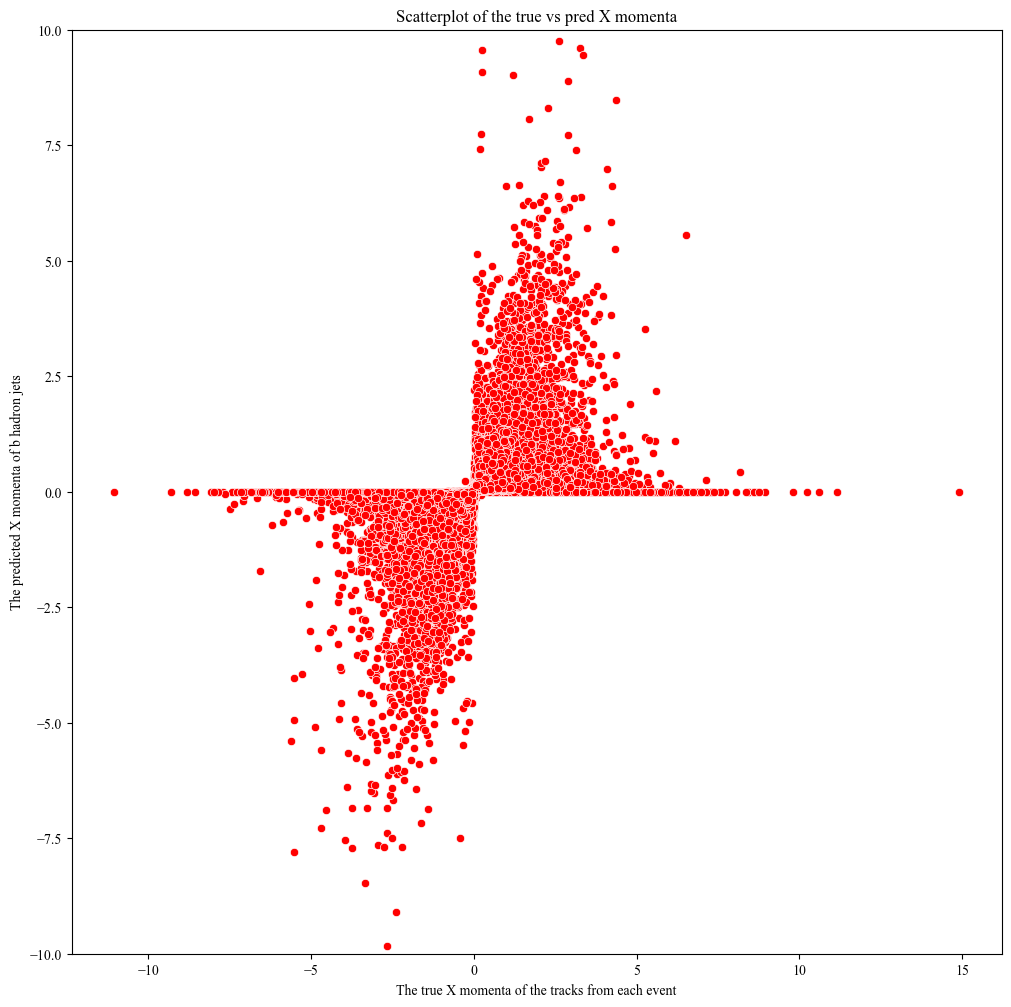

In [69]:
#Check to see whether there are correlations between the training features and targets.
fig,ax = plt.subplots(figsize = (12,12))
sns.scatterplot(
    y = X_train[:,0,2],
    x = y_train[:,2],
    color = "red"
)
ax.set_ylim(-10,10)
ax.set_title("Scatterplot of the true vs pred X momenta")
ax.set_xlabel("The true X momenta of the tracks from each event")
ax.set_ylabel("The predicted X momenta of b hadron jets")
fig.savefig("/home/physics/phujdj/DeepLearningParticlePhysics/ScatterplotXgboost")

In [33]:
#Trains the DeepSetProjector
history  = DeepSetProjector.fit(
    (Tracks_input_scaled,b_jets_input_scaled), y = {"MultivariateLoss":Standardized_Bhads_targets, "MassOutput":onehot},
    validation_split = 0.1,
    epochs = EPOCHS,
    batch_size = BATCHSIZE,
    callbacks = [early_stopping, cp_callback, reduce_learn_on_plateau],
    )

Epoch 1/1000
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Instructions for updating:
Use fn_output_signature instead
908/908 [==============================] - 27s 20ms/step - loss: 88.8571 - MultivariateLoss_loss: 24.6100 - MassOutput_loss: 2.5074 - MultivariateLoss_Mean_Squared_Error: 1.5176 - MassOutput_Mean_Squared_Error: 0.0754 - val_loss: 82.3848 - val_MultivariateLoss_loss: 19.3931 - val_MassOutput_loss: 2.3902 - val_MultivariateLoss_Mean_Squared_Error: 1.2413 - val_MassOutput_Mean_Squared_Error: 0.0747 - lr: 1.0000e-05
Epoch 2/1000
908/908 [==============================] - 17s 19ms/step - loss: 80.3241 - MultivariateLoss_loss: 18.4951 - MassOutput_loss: 2.3094 - MultivariateLoss_Mean_Squared_Error: 1.1485 - MassOutput_Mean_Squared_Error: 0.0731 - val_loss: 78.8629 - val_MultivariateLoss_loss: 18.1760 - val_MassOutput_loss: 

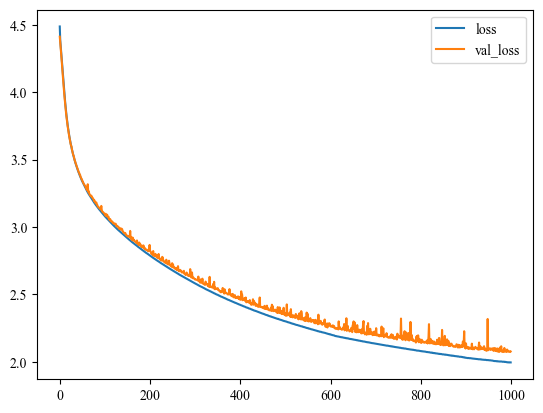

In [34]:
# Plot the loss and validation curves vs epoch
history_df = pd.DataFrame(history.history)
np.log(history_df.loc[:, ["loss","val_loss"]]).plot()
history_df.to_csv('/home/physics/phujdj/DeepLearningParticlePhysics/history.csv')

In [35]:
#Evaluate the entire performance of the model
loss = DeepSetProjector.evaluate((Tracks_input_scaled,b_jets_input_scaled),(Standardized_Bhads_targets, onehot),verbose = 2)
print("The Loaded DeepNet has loss: ", loss)

2016/2016 - 8s - loss: 7.4051 - MultivariateLoss_loss: 3.1911 - MassOutput_loss: 1.4270 - MultivariateLoss_Mean_Squared_Error: 0.3639 - MassOutput_Mean_Squared_Error: 0.0586 - 8s/epoch - 4ms/step
The Loaded DeepNet has loss:  [7.405147552490234, 3.1911044120788574, 1.4270219802856445, 0.3639273941516876, 0.0585884228348732]


In [ ]:
#Evaluates the performance of the trained model when fed jet and track features scaled.

In [70]:
predictions = DeepSetProjector.predict((Tracks_input_scaled, b_jets_input_scaled))

2016/2016 [==============================] - 7s 3ms/step


In [76]:
#Uses monte carlo dropout to generate 100 predictions which are than aggregrated to make the final predictions.
Predictions = np.stack([DeepSetProjector((Tracks_input_scaled, b_jets_input_scaled))[0] for sample in range(100)])
Predictions = Predictions.mean(axis = 0)

In [37]:
predictions[0].shape
predictions[1].shape

(64506, 12)

In [38]:
Predictions = predictions[0]
Predictions_Mass = predictions[1]

In [39]:
Predictions[:,:11].shape

(64506, 11)

In [ ]:
#Unstandardizes the predicted values and their associated uncertainties.

In [77]:
lister = []
index = 0
predictions_x = Predictions[:,:11]
for bhads_features in range(np.shape(predictions_x)[1]):
    Predictions_temp = predictions_x[:, bhads_features]
    Predictions_temp = (Predictions_temp*stds[index]) + means[index]
    Predictions_temp = Predictions_temp.reshape(-1,1)
    lister.append(Predictions_temp)
    index+=1
Predictions_X = np.concatenate(lister, axis = 1)
print(Predictions_X)

[[ 4.81495039e+04  1.22254367e+05  1.24451336e+05 ...  3.41552429e+01
   8.90698552e-01  5.30909033e+03]
 [-7.04631797e+04 -5.33671406e+04 -5.02275031e+05 ...  9.59850693e+01
   8.02119493e-01  5.30930078e+03]
 [ 1.34154111e+04 -2.82107852e+04  4.64888428e+03 ...  6.31062698e+00
   7.81712472e-01  5.31610791e+03]
 ...
 [ 1.72541504e+04  8.33806484e+04 -3.94570391e+04 ...  1.79184113e+01
   8.64807248e-01  5.32016846e+03]
 [ 1.09598877e+04  1.28767867e+05  2.40840078e+04 ...  2.41964798e+01
   8.73165846e-01  5.32139990e+03]
 [ 8.67867656e+04  3.89448120e+03  2.04081699e+04 ...  1.64027920e+01
   9.33111131e-01  5.30131299e+03]]


In [78]:
lister = []
index = 0
predictions_x_uncertainty = Predictions[:,11:22]
print(predictions_x_uncertainty)
for bhads_features in range(np.shape(predictions_x_uncertainty)[1]):
    Predictions_temp = predictions_x_uncertainty[:, bhads_features]
    Predictions_temp = (Predictions_temp*stds[index]) + means[index]
    Predictions_temp = Predictions_temp.reshape(-1,1)
    lister.append(Predictions_temp)
    index+=1
Predictions_Uncertainty = np.concatenate(lister, axis = 1)
print(Predictions_Uncertainty)

[[0.07846792 0.29507408 0.07365284 ... 0.17230423 0.52098936 0.94291824]
 [0.17023551 0.1410899  0.39038113 ... 0.59729517 0.60597926 1.1579182 ]
 [0.05830005 0.08357049 0.01036042 ... 0.05362957 0.77368623 1.0528241 ]
 ...
 [0.04159652 0.20594168 0.02550099 ... 0.08684173 0.546235   1.2073276 ]
 [0.06383397 0.41008458 0.03226682 ... 0.16429377 0.76668906 1.169904  ]
 [0.16215748 0.0202359  0.01382573 ... 0.06780738 0.49863192 0.8396993 ]]
[[5.2398765e+03 1.9233840e+04 1.3910483e+04 ... 3.5501499e+01
  8.8977432e-01 5.3900391e+03]
 [1.1229235e+04 9.1353301e+03 7.6853891e+04 ... 4.7243248e+01
  9.0833199e-01 5.4090029e+03]
 [3.9235889e+03 5.3631221e+03 1.3323809e+03 ... 3.2222729e+01
  9.4495094e-01 5.3997334e+03]
 ...
 [2.8334060e+03 1.3388405e+04 4.3412656e+03 ... 3.3140320e+01
  8.9528674e-01 5.4133608e+03]
 [4.2847686e+03 2.6776398e+04 5.6858394e+03 ... 3.5280186e+01
  9.4342315e-01 5.4100601e+03]
 [1.0702010e+04 1.2095463e+03 2.0210415e+03 ... 3.2614437e+01
  8.8489258e-01 5.380934

In [ ]:
#Evaluates the performance of the model by 
#plotting the resolutions, pulls and scatterplots.

In [43]:
print(Predictions_Mass[0])

[2.86645561e-01 1.23542242e-01 4.32309031e-01 1.09394446e-01
 2.36798711e-02 1.54380873e-02 3.68803227e-03 1.04717899e-03
 4.17925511e-03 2.97544957e-05 4.65141529e-05 3.97083061e-12]


In [88]:
Error_px_unscaled = bhads_targets[:,0] - Predictions_X[:,0]
Pull_bhads_px_unscaled = Error_px_unscaled/np.std(bhads[:,0])
Pull_px = Error_px_unscaled/Predictions_Uncertainty[:,0]

In [89]:
Error_py_unscaled = bhads_targets[:,1] - Predictions_X[:,1]
Pull_bhads_py_unscaled = Error_py_unscaled/np.std(bhads[:,1])
Pull_py = Error_py_unscaled/Predictions_Uncertainty[:,1]

In [90]:
Error_pz_unscaled = bhads_targets[:,2] - Predictions_X[:,2]
Pull_bhads_pz_unscaled = Error_pz_unscaled/np.std(bhads[:,2])
Pull_pz = Error_px_unscaled/Predictions_Uncertainty[:,2]

In [140]:
Error_projection_unscaled = bhads_targets[:,9] - Predictions_X[:,9]
Pull_bhads_projection_unscaled = Error_projection_unscaled/np.std(bhads_targets[:,10])
Pull_projection = Error_projection_unscaled/Predictions_Uncertainty[:,10]

In [92]:
Error_pxfraction_unscaled = bhads_targets[:,3] - Predictions_X[:,3]
Pull_pxfraction_unscaled = Error_pxfraction_unscaled/np.std(bhads_targets[:,3])
Pull_pxfraction = Error_pxfraction_unscaled/Predictions_Uncertainty[:,3]

In [93]:
Error_pyfraction_unscaled = bhads_targets[:,4] - Predictions_X[:,4]
Pull_pyfraction_unscaled = Error_pyfraction_unscaled/np.std(bhads_targets[:,4])
Pull_pyfraction = Error_pyfraction_unscaled/Predictions_Uncertainty[:,4]

In [94]:
Error_pzfraction_unscaled = bhads_targets[:,5] - Predictions_X[:,5]
Pull_pzfraction_unscaled = Error_pzfraction_unscaled/np.std(bhads_targets[:,5])
Pull_pzfraction = Error_pzfraction_unscaled/Predictions_Uncertainty[:,5]

In [95]:
Error_energy_unscaled = bhads_targets[:,6] - Predictions_X[:,6]
Pull_energy_unscaled = Error_energy_unscaled/np.std(bhads_targets[:,6])
Pull_energy = Error_energy_unscaled/Predictions_Uncertainty[:,6]

-268.12363940414474
15258.850204237136


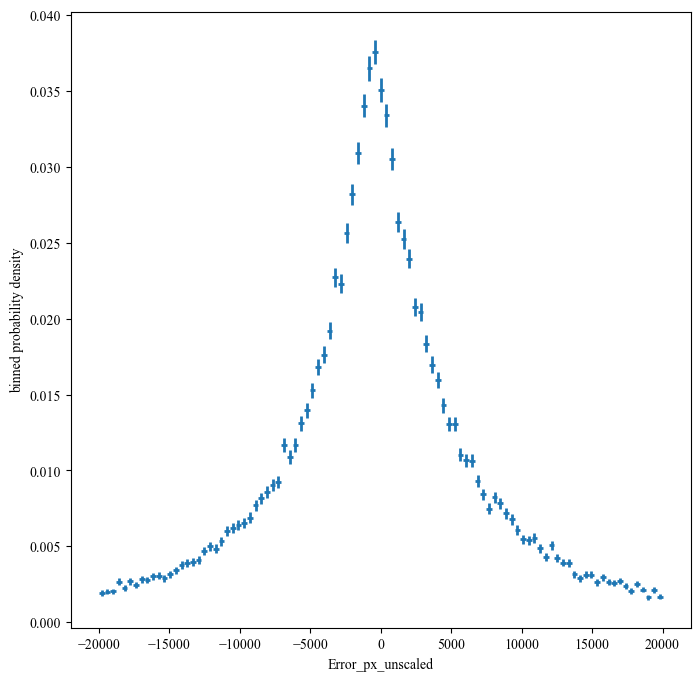

In [96]:
print(np.mean(Error_px_unscaled))
print(np.std(Error_px_unscaled))
binneddensity(Error_px_unscaled, fixedbinning(-20000,20000,100),xlabel = "Error_px_unscaled")

-0.055971414139097155
1.0169591485477607


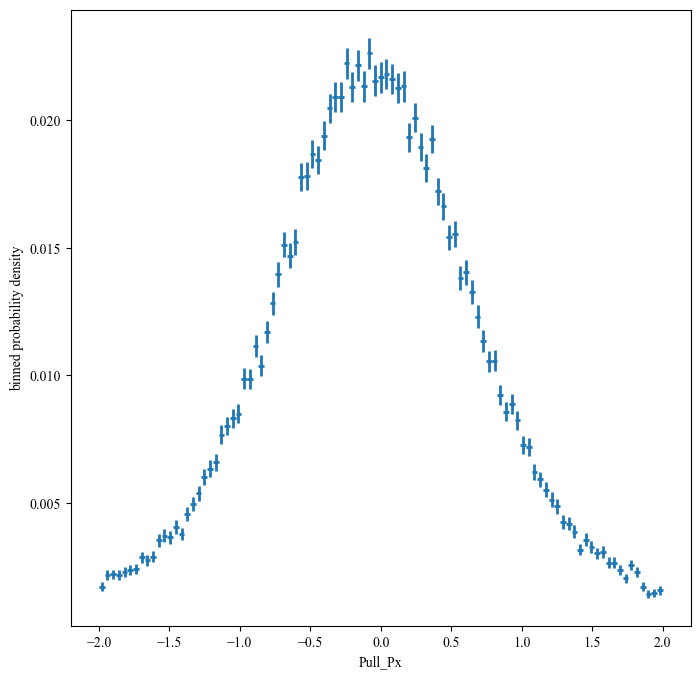

In [102]:
print(np.mean(Pull_px))
print(np.std(Pull_px))
binneddensity(Pull_px, fixedbinning(-2,2,100),xlabel = "Pull_Px")

-313.6570076875554
15395.980168702286


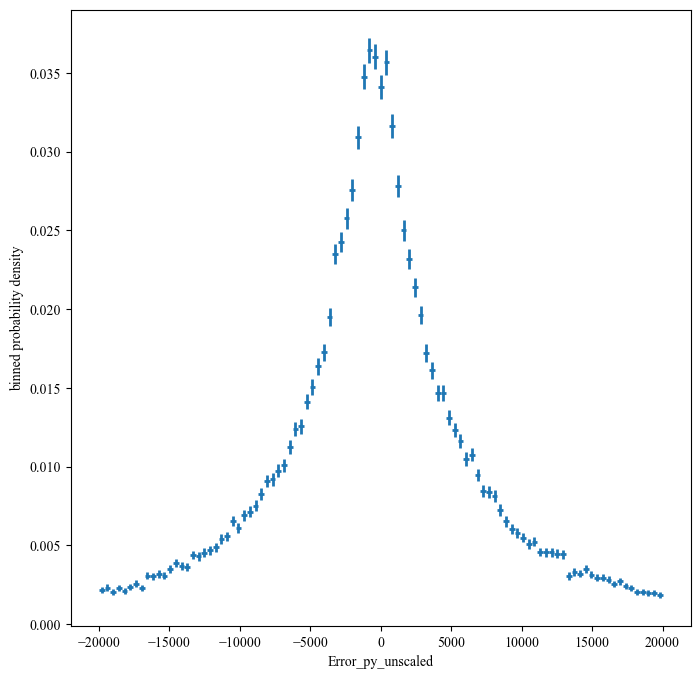

In [97]:
print(np.mean(Error_py_unscaled))
print(np.std(Error_py_unscaled))
binneddensity(Error_py_unscaled, fixedbinning(-20000,20000,100),xlabel = "Error_py_unscaled")

-0.06147603237113183
1.0330278561997364


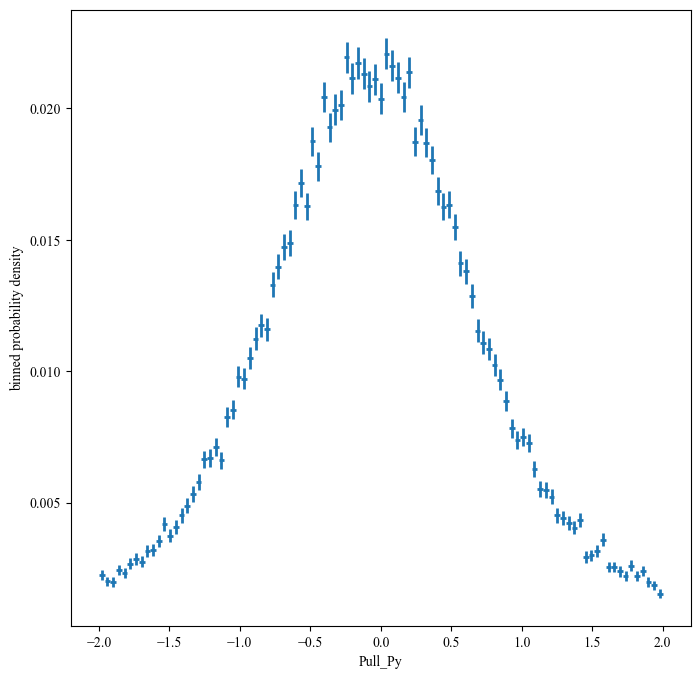

In [103]:
print(np.mean(Pull_py))
print(np.std(Pull_py))
binneddensity(Pull_py, fixedbinning(-2,2,100),xlabel = "Pull_Py")

-605.9312109026657
48030.87119490436


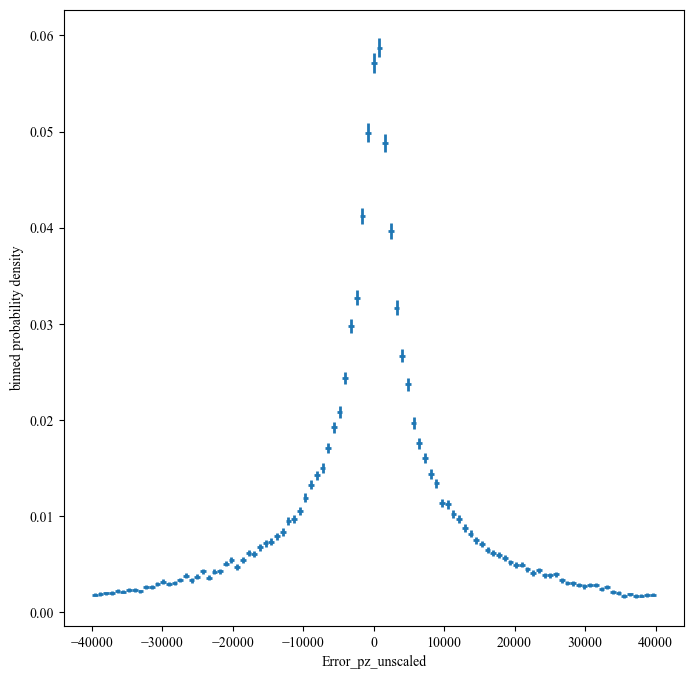

In [98]:
print(np.mean(Error_pz_unscaled))
print(np.std(Error_pz_unscaled))
binneddensity(Error_pz_unscaled, fixedbinning(-40000,40000,100),xlabel = "Error_pz_unscaled")

-0.07091054696888581
2.084399041534052


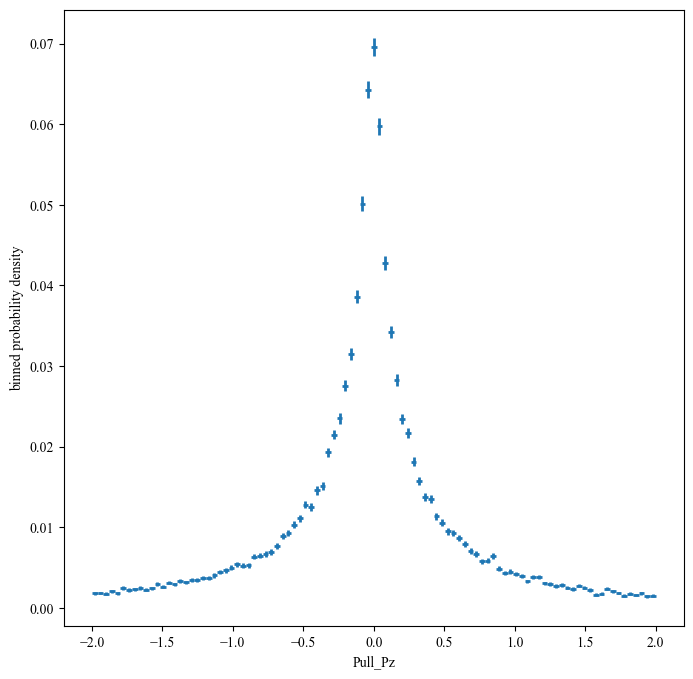

In [104]:
print(np.mean(Pull_pz))
print(np.std(Pull_pz))
binneddensity(Pull_pz, fixedbinning(-2,2,100),xlabel = "Pull_Pz")

-0.0036925535619246287
0.16195234914954207


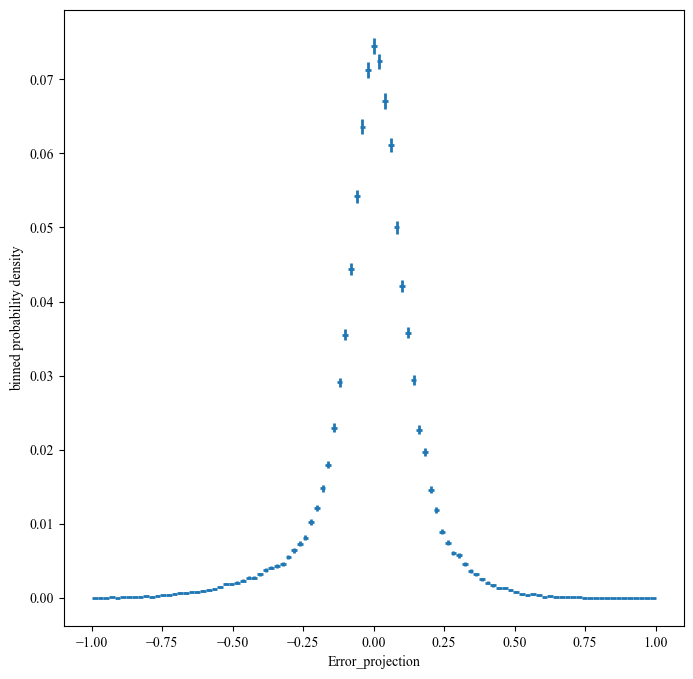

In [144]:
print(np.mean(Error_projection_unscaled))
print(np.std(Error_projection_unscaled))
binneddensity(Error_projection_unscaled, fixedbinning(-1,1,100),xlabel = "Error_projection")

-6.851014150212196e-07
3.0035199023068194e-05


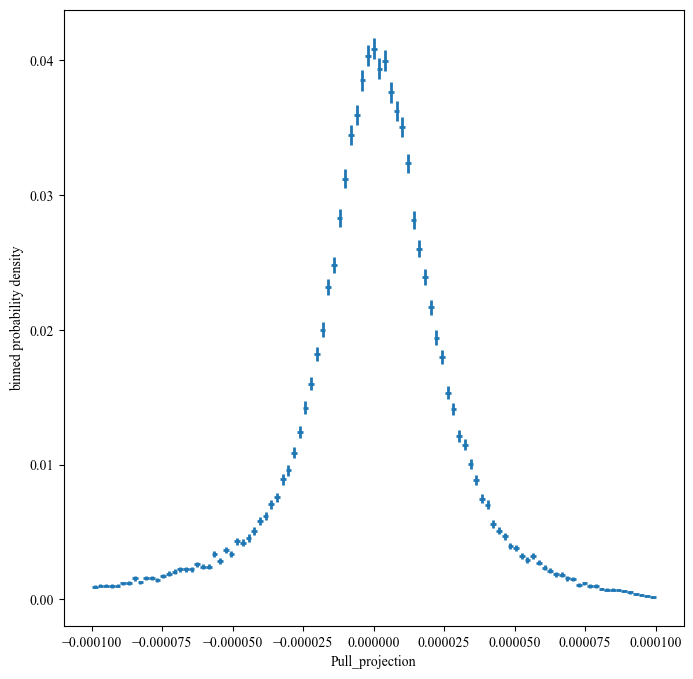

In [146]:
print(np.mean(Pull_projection))
print(np.std(Pull_projection))
binneddensity(Pull_projection, fixedbinning(-0.0001,0.0001,100),xlabel = "Pull_projection")

-0.0025283733912564214
0.17646005125914027


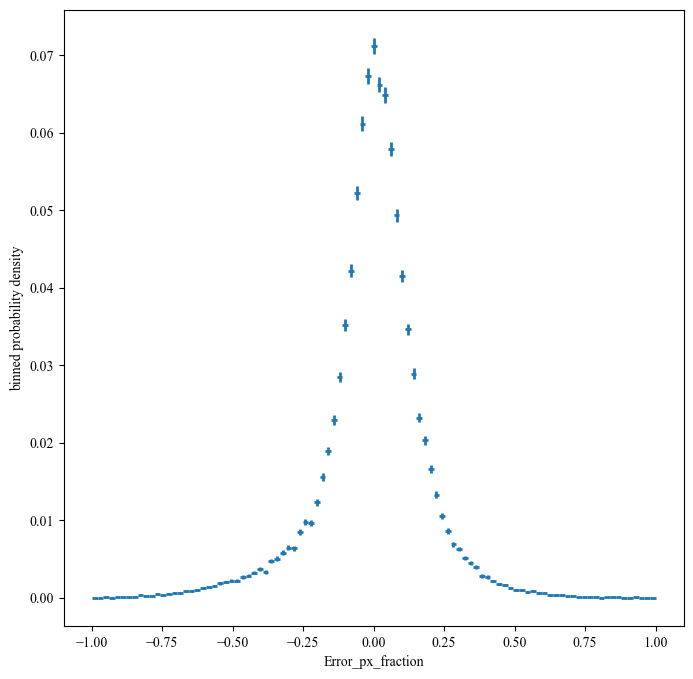

In [107]:
print(np.mean(Error_pxfraction_unscaled))
print(np.std(Error_pxfraction_unscaled))
binneddensity(Error_pxfraction_unscaled, fixedbinning(-1,1,100),xlabel = "Error_px_fraction")

-0.01107777901322362
0.7731395446854782


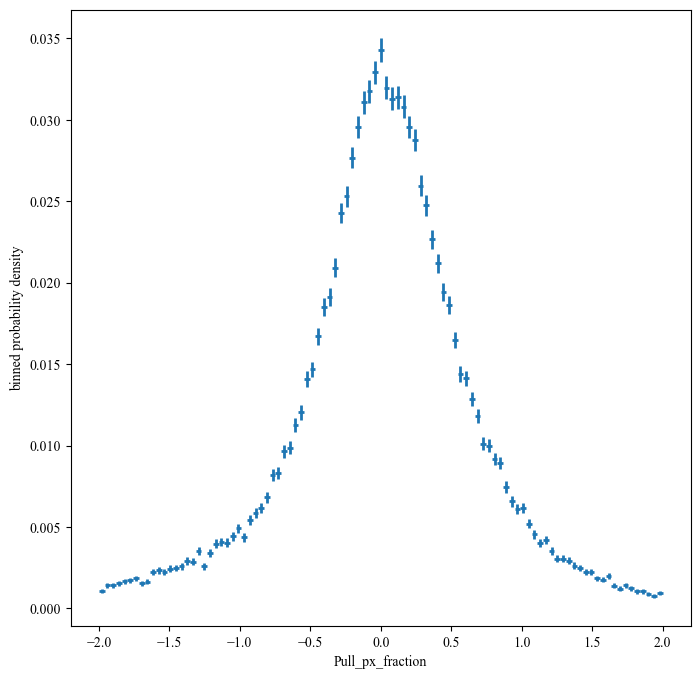

In [148]:
print(np.mean(Pull_pxfraction_unscaled))
print(np.std(Pull_pxfraction_unscaled))
binneddensity(Pull_pxfraction_unscaled, fixedbinning(-2,2,100),xlabel = "Pull_px_fraction")

-0.0043075789044496665
0.17389923147832237


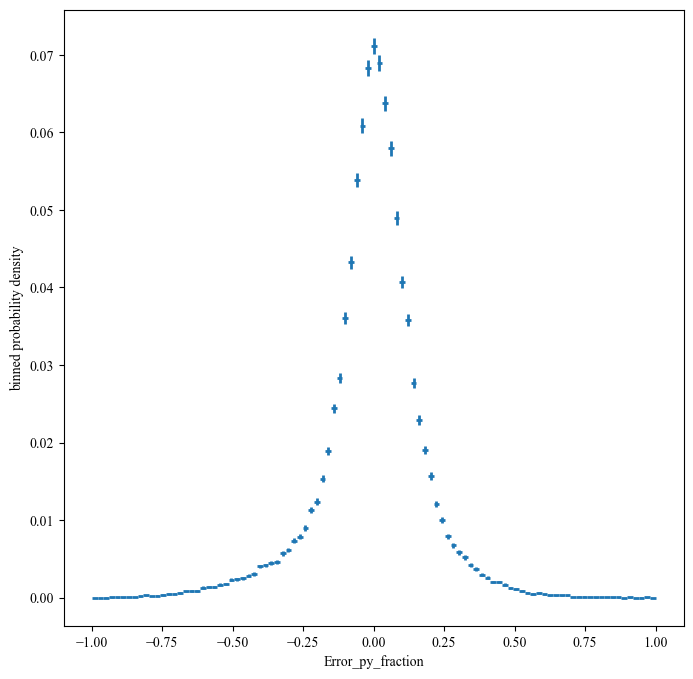

In [130]:
print(np.mean(Error_pyfraction_unscaled))
print(np.std(Error_pyfraction_unscaled))
binneddensity(Error_pyfraction_unscaled, fixedbinning(-1,1,100),xlabel = "Error_py_fraction")

-0.019064865861376533
0.7696586864853382


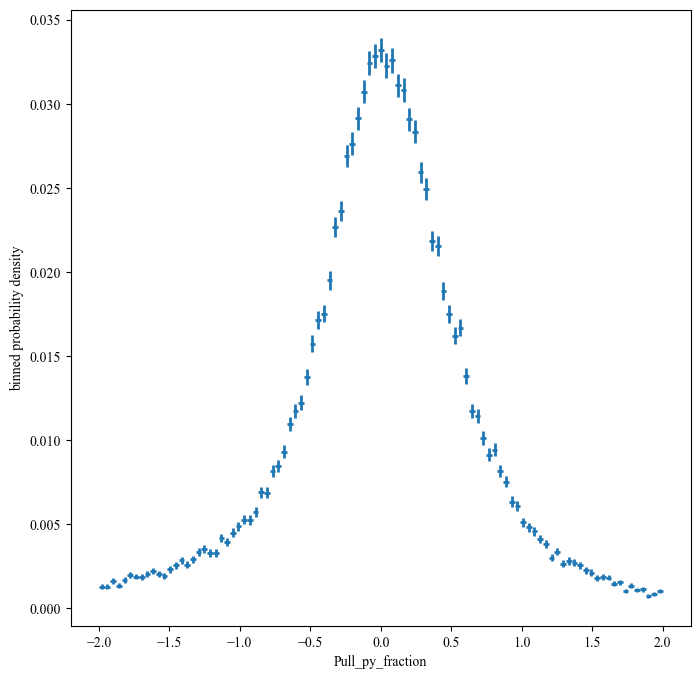

In [131]:
print(np.mean(Pull_pyfraction_unscaled))
print(np.std(Pull_pyfraction_unscaled))
binneddensity(Pull_pyfraction_unscaled, fixedbinning(-2,2,100),xlabel = "Pull_py_fraction")

-0.0012464266405589283
0.3387585333214061


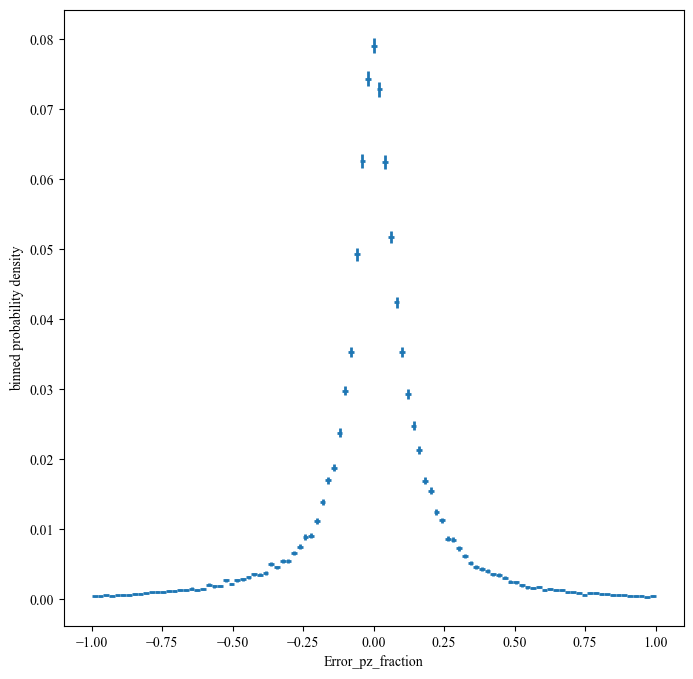

In [132]:
print(np.mean(Error_pzfraction_unscaled))
print(np.std(Error_pzfraction_unscaled))
binneddensity(Error_pzfraction_unscaled, fixedbinning(-1,1,100),xlabel = "Error_pz_fraction")

-0.0012464266405589285
0.33875853332140615


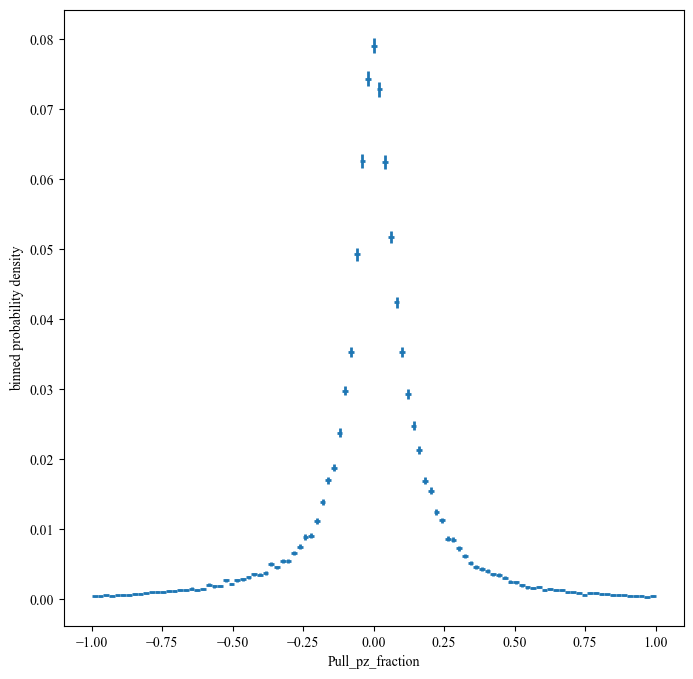

In [133]:
print(np.mean(Pull_pzfraction_unscaled))
print(np.std(Pull_pzfraction_unscaled))
binneddensity(Pull_pzfraction_unscaled, fixedbinning(-1,1,100),xlabel = "Pull_pz_fraction")

86.35907683700061
21275.130461041477


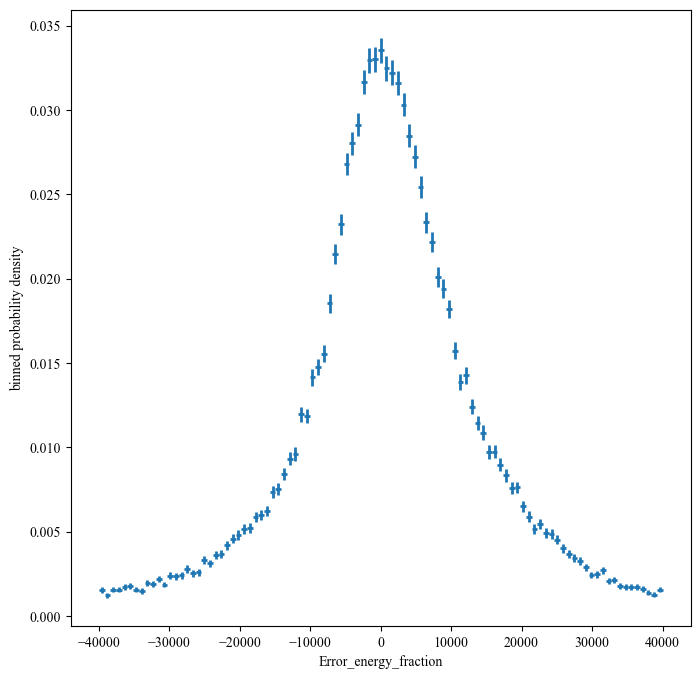

In [134]:
print(np.mean(Error_energy_unscaled))
print(np.std(Error_energy_unscaled))
binneddensity(Error_energy_unscaled, fixedbinning(-40000,40000,100),xlabel = "Error_energy_fraction")

0.0020630240568263853
0.5082396380416517


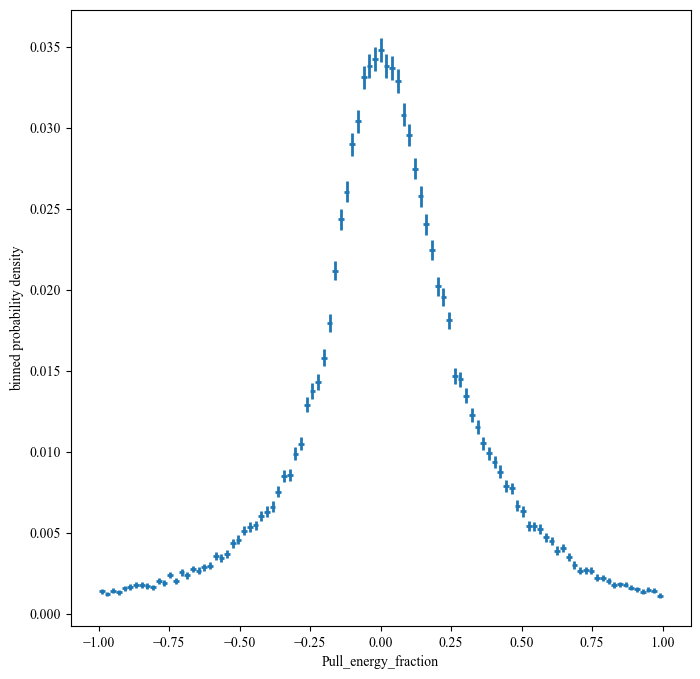

In [117]:
print(np.mean(Pull_energy_unscaled))
print(np.std(Pull_energy_unscaled))
binneddensity(Pull_energy_unscaled, fixedbinning(-1,1,100),xlabel = "Pull_energy_fraction")

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'The predicted X momenta of b hadron jets')

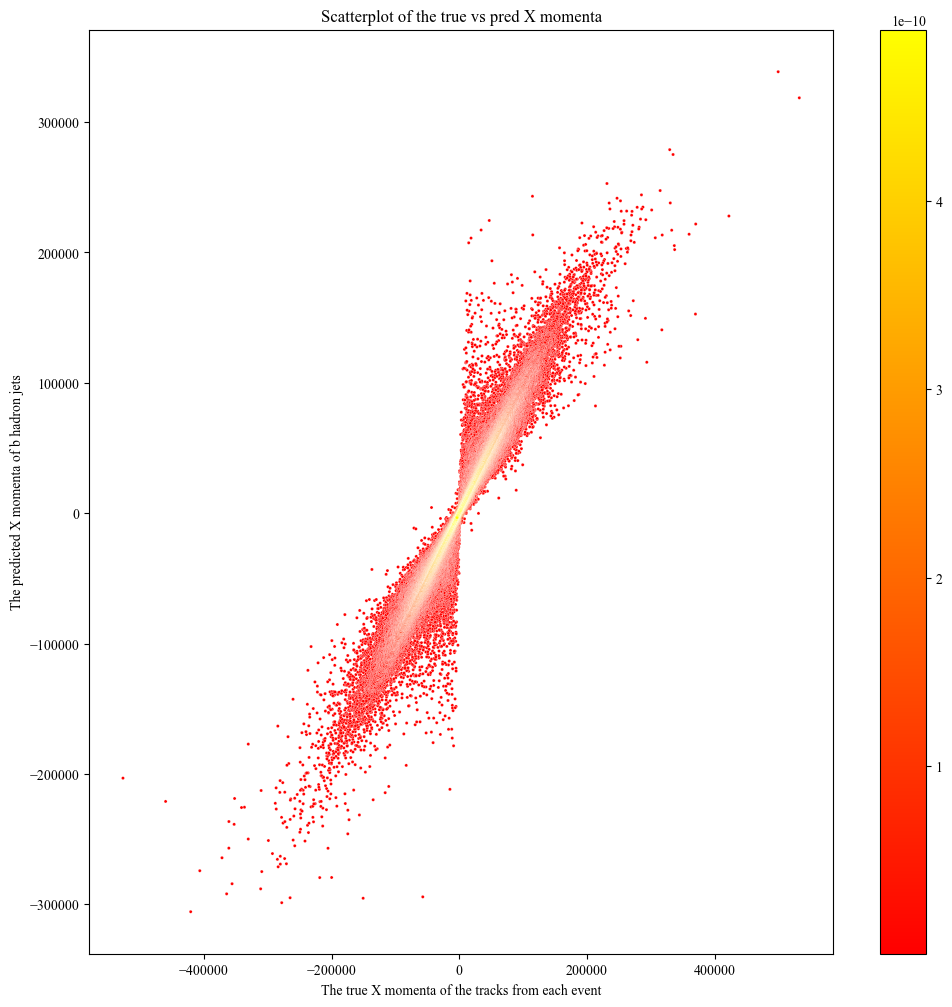

In [153]:
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets[:,0]
y = Predictions_X[:,0]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "autumn",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "autumn", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred X momenta")
ax.set_xlabel("The true X momenta of the tracks from each event")
ax.set_ylabel("The predicted X momenta of b hadron jets")

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'The predicted Y momenta of b hadron jets')

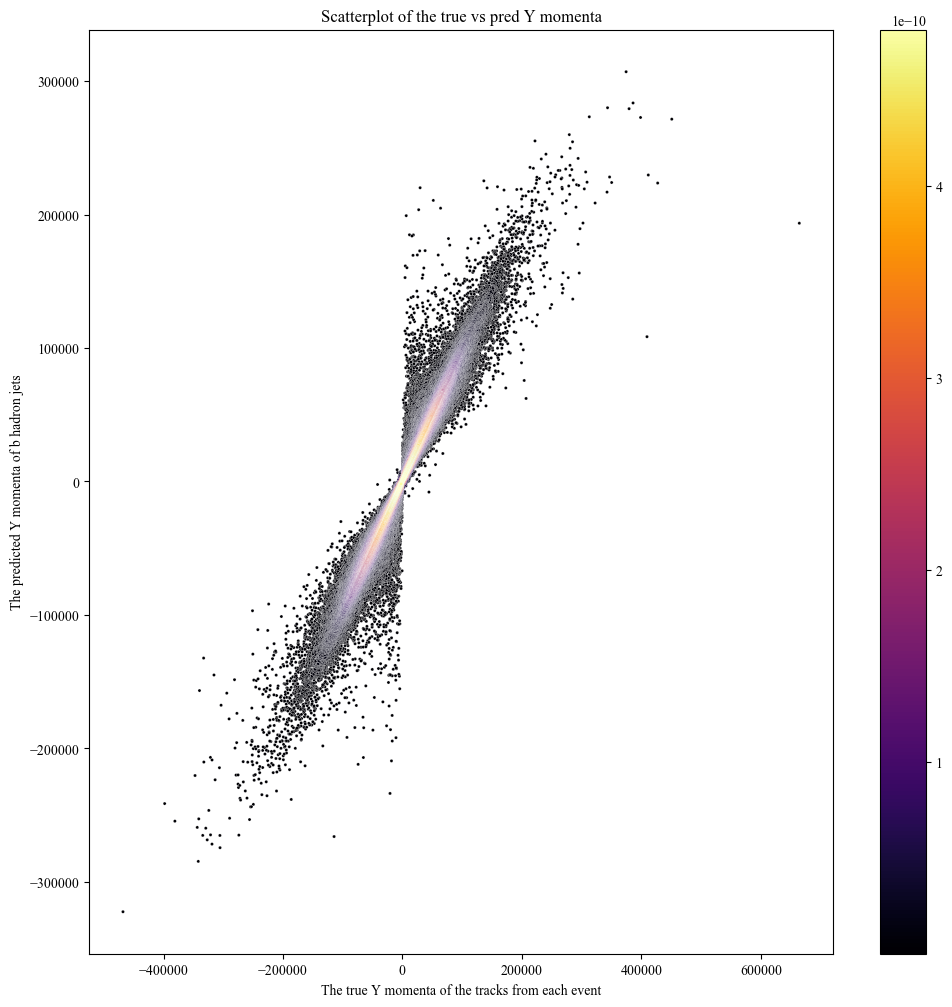

In [154]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets[:,1]
y = Predictions_X[:,1]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "inferno",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "inferno", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred Y momenta")
ax.set_xlabel("The true Y momenta of the tracks from each event")
ax.set_ylabel("The predicted Y momenta of b hadron jets")

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'The predicted Z momenta of b hadron jets')

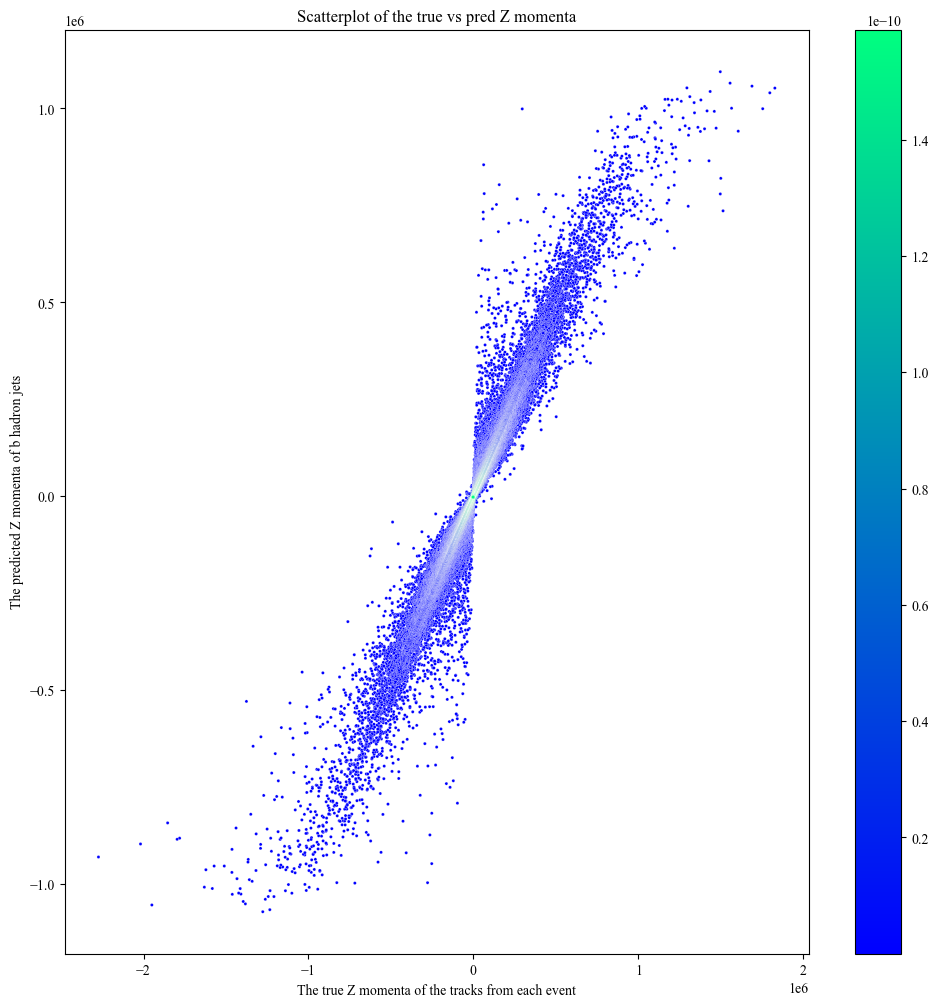

In [155]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets[:,2]
y = Predictions_X[:,2]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "winter",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "winter", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred Z momenta")
ax.set_xlabel("The true Z momenta of the tracks from each event")
ax.set_ylabel("The predicted Z momenta of b hadron jets")

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'The predicted X fraction of b hadron jets')

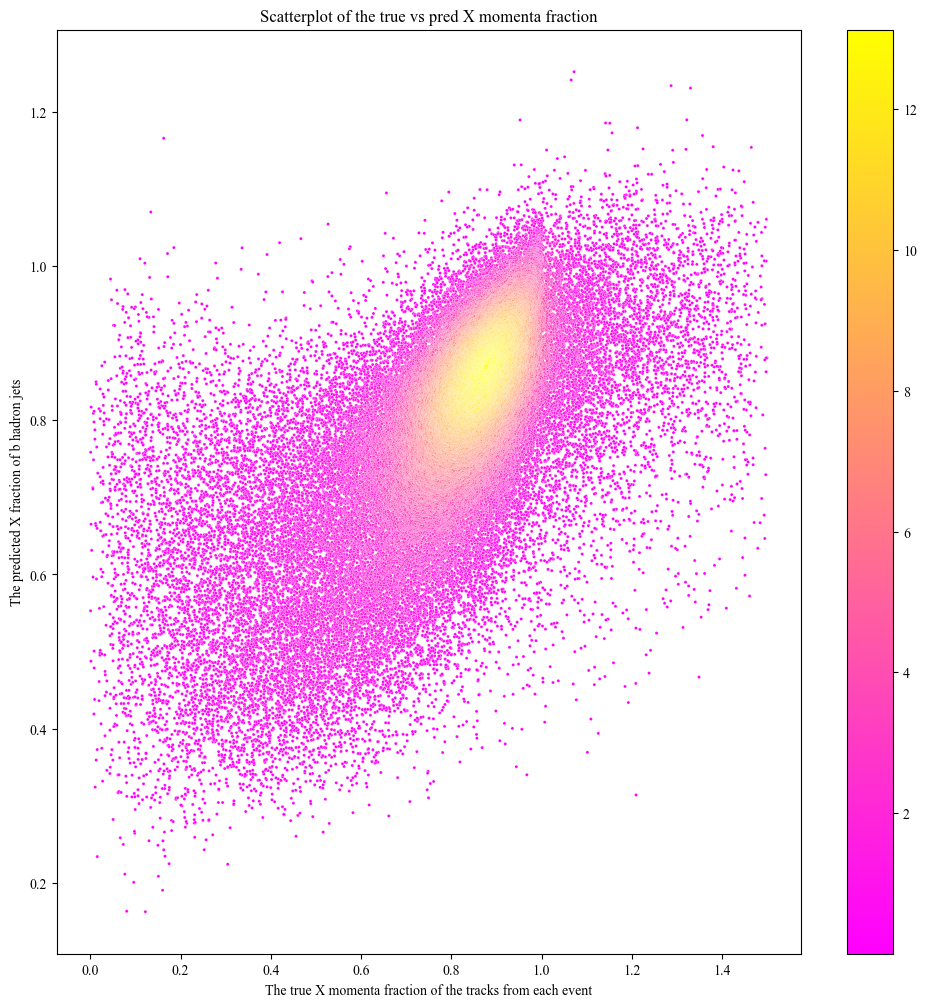

In [156]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets[:,3]
y = Predictions_X[:,3]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "spring",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "spring", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred X momenta fraction")
ax.set_xlabel("The true X momenta fraction of the tracks from each event")
ax.set_ylabel("The predicted X fraction of b hadron jets")

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'The predicted Y fraction of b hadron jets')

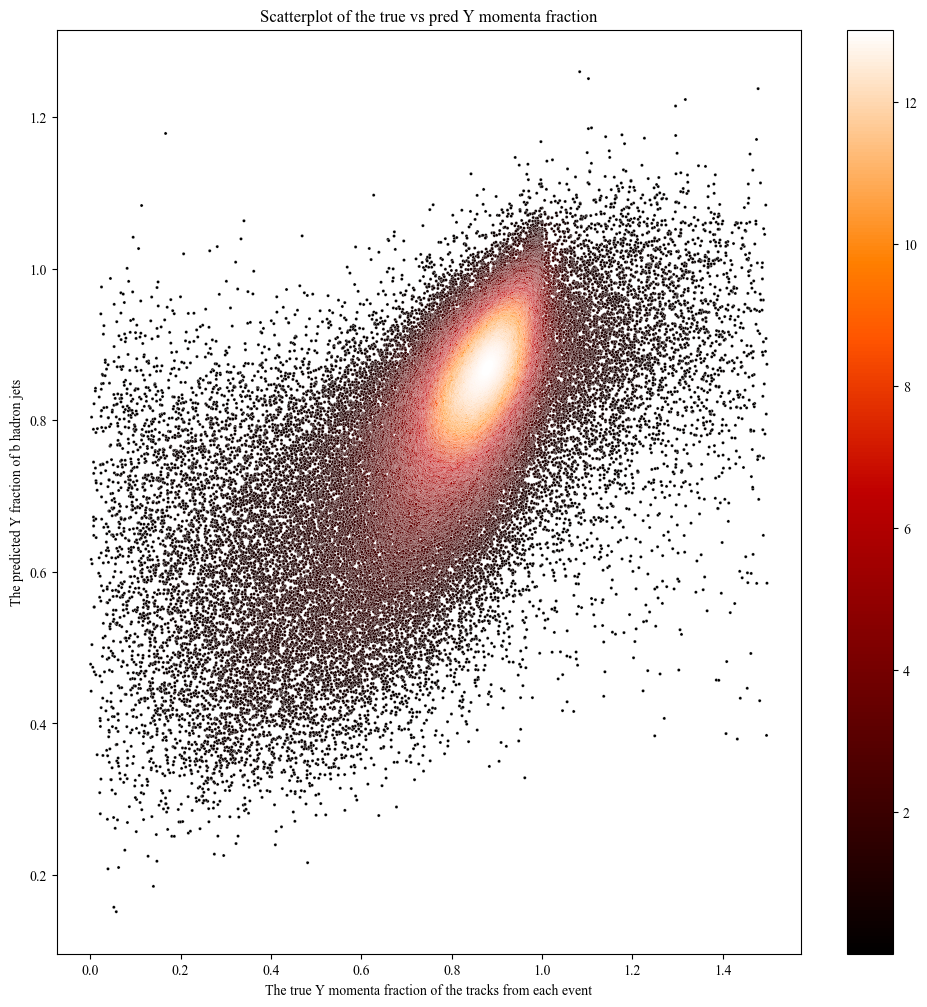

In [157]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets[:,4]
y = Predictions_X[:,4]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "gist_heat",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "gist_heat", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred Y momenta fraction")
ax.set_xlabel("The true Y momenta fraction of the tracks from each event")
ax.set_ylabel("The predicted Y fraction of b hadron jets")

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'The predicted Z fraction of b hadron jets')

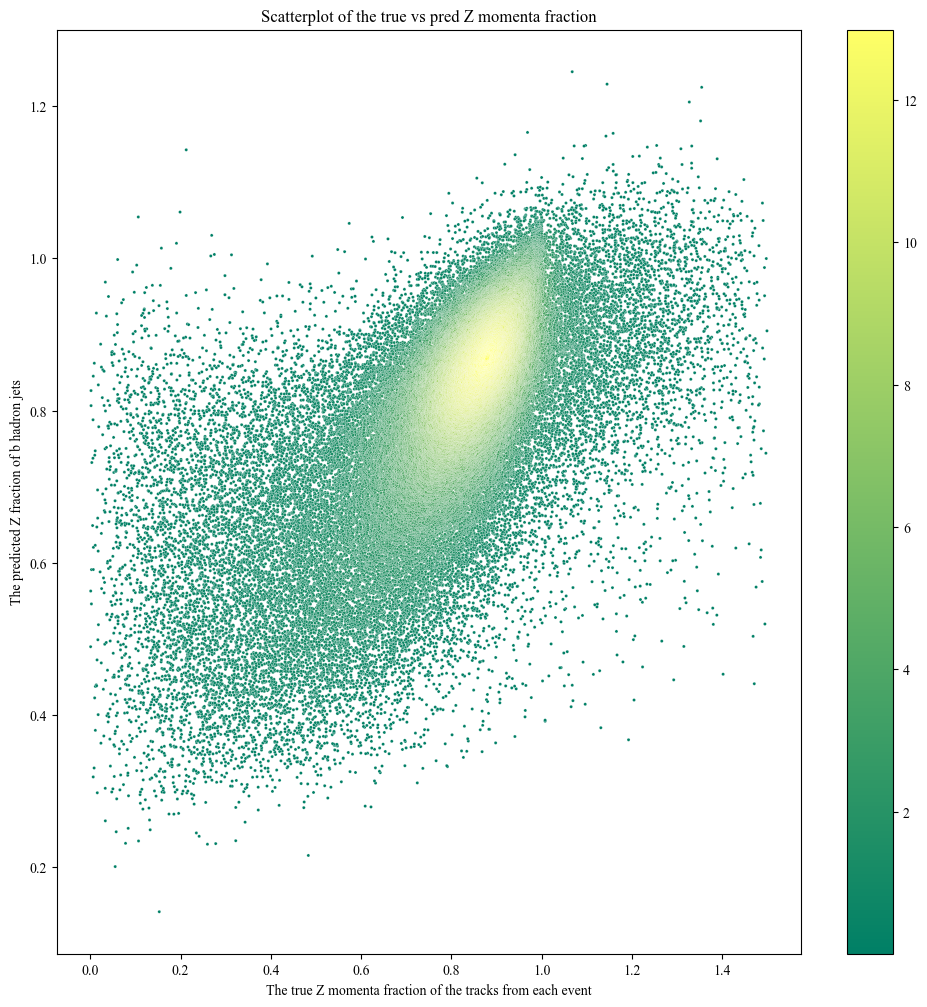

In [158]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets[:,5]
y = Predictions_X[:,5]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "summer",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "summer", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred Z momenta fraction")
ax.set_xlabel("The true Z momenta fraction of the tracks from each event")
ax.set_ylabel("The predicted Z fraction of b hadron jets")

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'The predicted Bhadron Projection of b hadron jets')

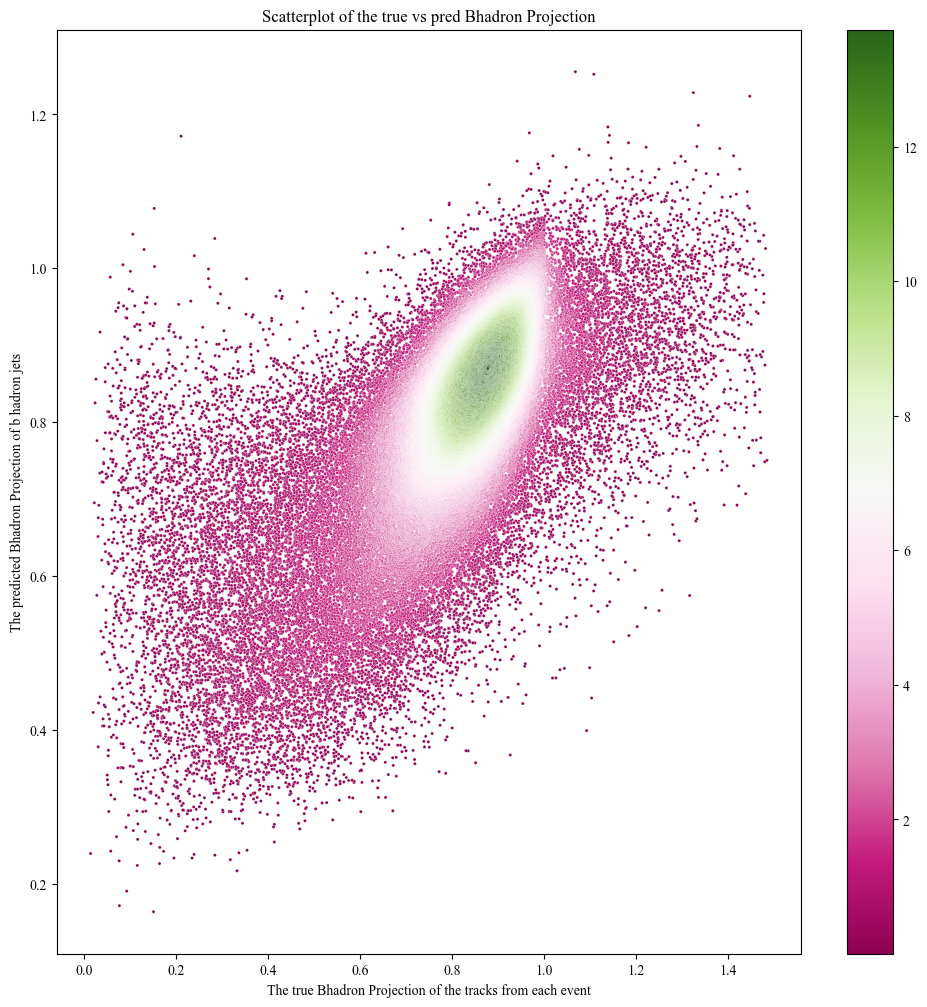

In [176]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets[:,9]
y = Predictions_X[:,9]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "PiYG",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "PiYG", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred Bhadron Projection")
ax.set_xlabel("The true Bhadron Projection of the tracks from each event")
ax.set_ylabel("The predicted Bhadron Projection of b hadron jets")

In [167]:
energy = (bhads_targets[:,6] * np.std(bhads_energy)) + np.mean(bhads_energy)
energy_predictions = (Predictions[:,6]*np.std(bhads_energy)) + np.mean(bhads_energy)
print(energy, energy_predictions)

[185747.90916647 552893.71064889  32230.16099056 ... 108796.79449304
 138190.61696981  92065.36820323] [179224.12  506508.16   33193.516 ...  94692.63  130673.66   87396.48 ]


In [163]:
np.shape(energy)
np.shape(bhads_targets[:,6])

(64506,)

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'The predicted B-hadron Energy of b hadron jets')

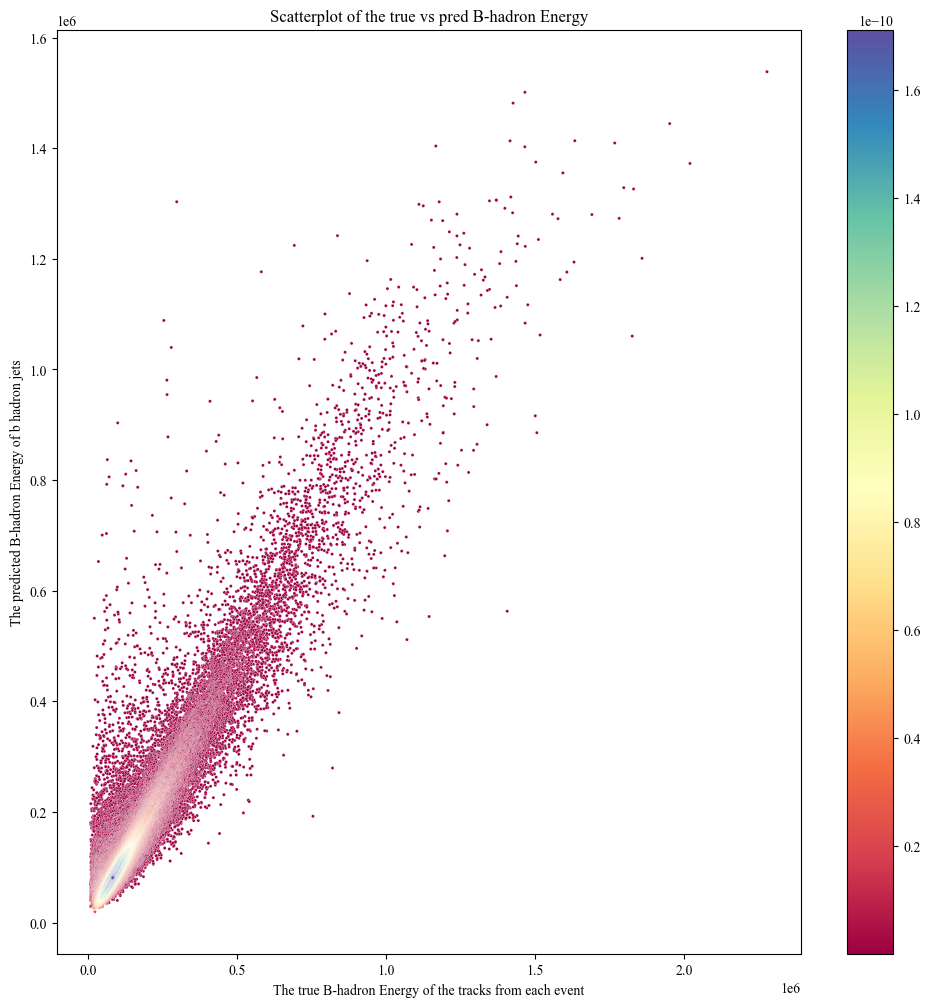

In [174]:
fig, ax = plt.subplots(figsize = (12,12))
x = energy
y = energy_predictions
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "Spectral",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "Spectral", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred B-hadron Energy")
ax.set_xlabel("The true B-hadron Energy of the tracks from each event")
ax.set_ylabel("The predicted B-hadron Energy of b hadron jets")

In [179]:
Predictions_Mass.shape
onehot.shape

(64506, 12)

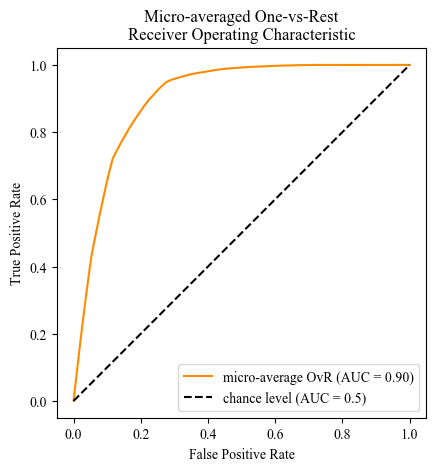

In [182]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(
    onehot.ravel(),
    Predictions_Mass.ravel(),
    name="micro-average OvR",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()

In [183]:
from sklearn.metrics import roc_auc_score

micro_roc_auc_ovr = roc_auc_score(
    onehot,
    Predictions_Mass,
    multi_class="ovr",
    average="micro",
)

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.90


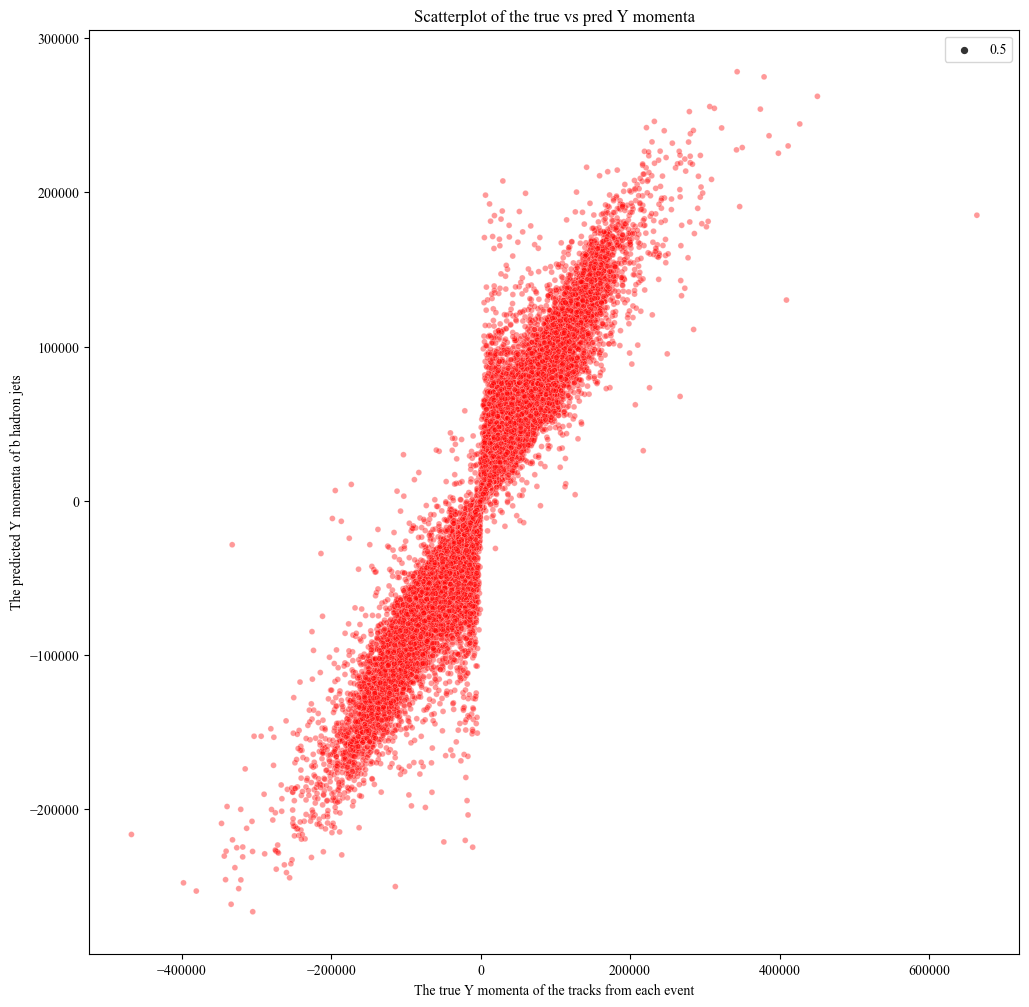

In [67]:
fig,ax = plt.subplots(figsize = (12,12))
sns.scatterplot(
    y = Predictions[:,1],
    x = bhads_targets[:,1],
    color = "red",
    alpha = 0.4,
    size = 0.5,
)
ax.set_title("Scatterplot of the true vs pred Y momenta")
ax.set_xlabel("The true Y momenta of the tracks from each event")
ax.set_ylabel("The predicted Y momenta of b hadron jets")
fig.savefig("/home/physics/phujdj/DeepLearningParticlePhysics/ScatterplotXgboost")

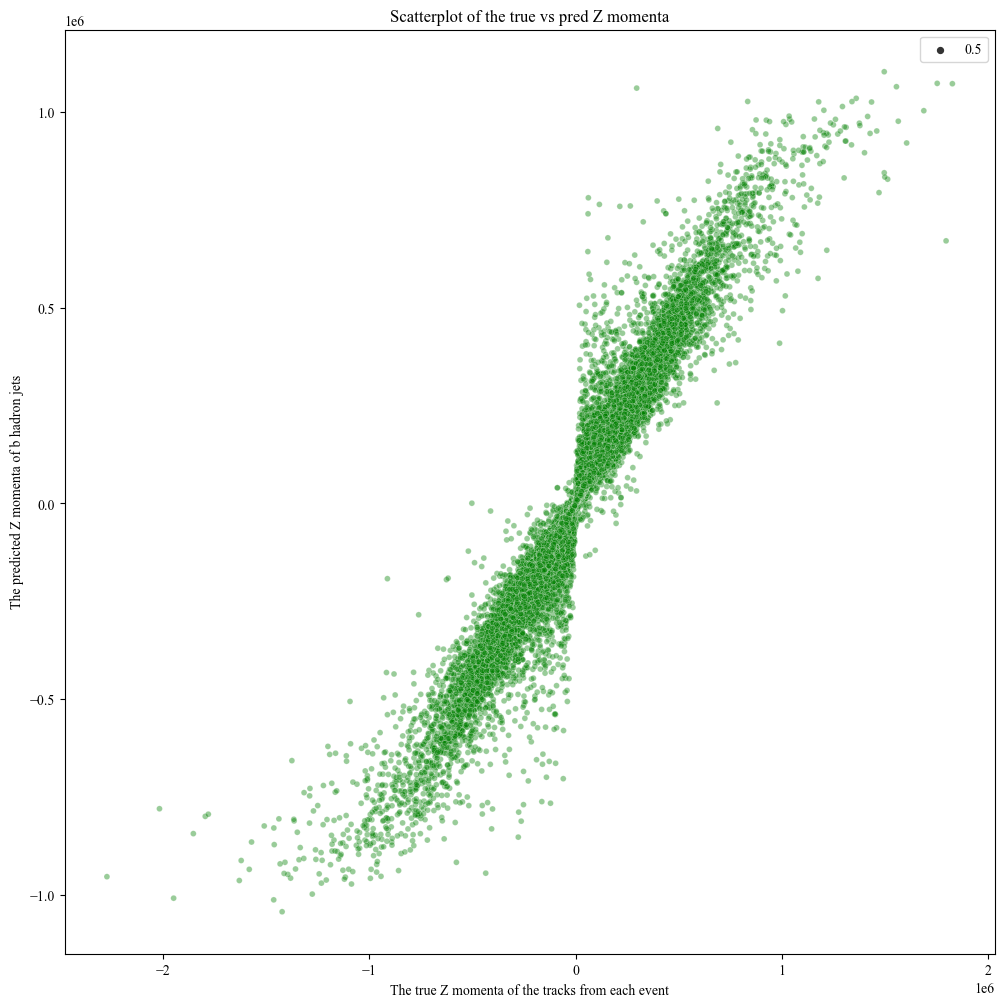

In [68]:
fig,ax = plt.subplots(figsize = (12,12))
sns.scatterplot(
    y = Predictions[:,2],
    x = bhads_targets[:,2],
    color = "green",
    alpha = 0.4,
    size = 0.5,
)
ax.set_title("Scatterplot of the true vs pred Z momenta")
ax.set_xlabel("The true Z momenta of the tracks from each event")
ax.set_ylabel("The predicted Z momenta of b hadron jets")
fig.savefig("/home/physics/phujdj/DeepLearningParticlePhysics/ScatterplotXgboost")

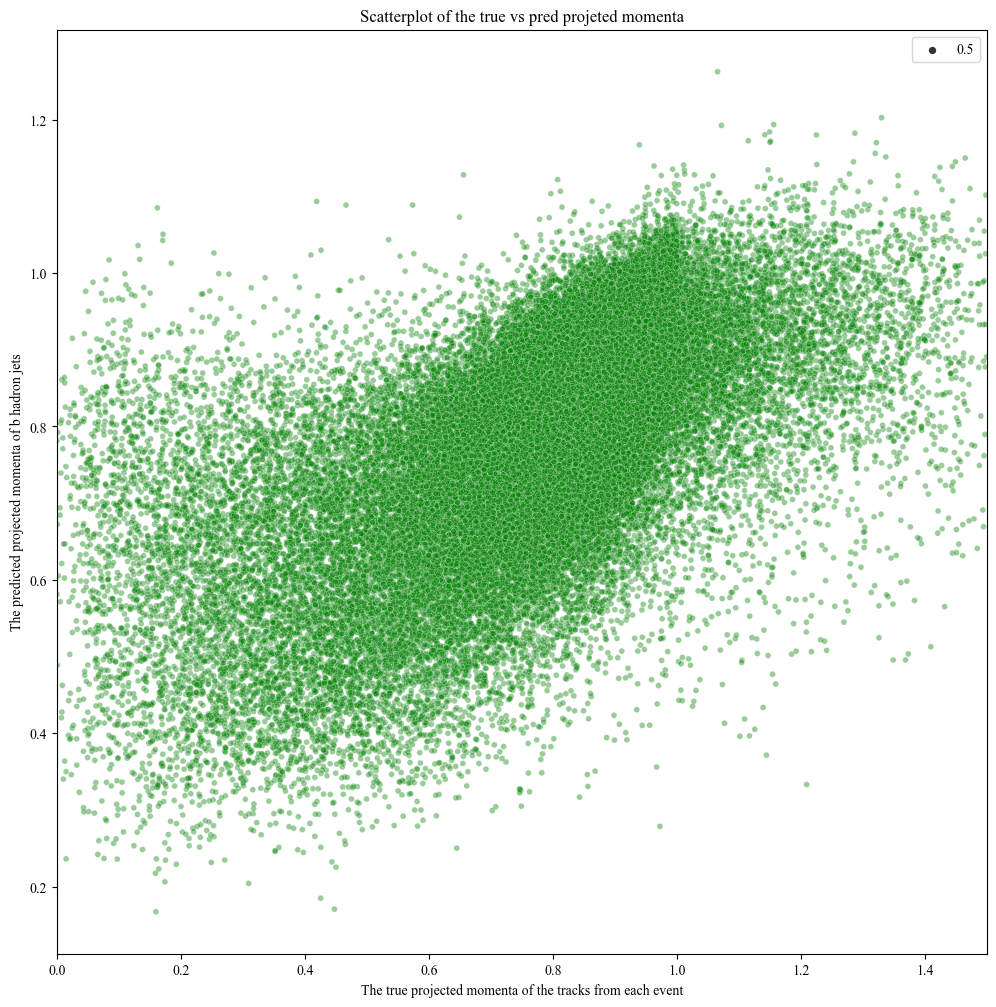

In [69]:
fig,ax = plt.subplots(figsize = (12,12))
sns.scatterplot(
    y = Predictions[:,3],
    x = bhads_targets[:,3],
    color = "green",
    alpha = 0.4,
    size = 0.5,
)
ax.set_xlim([0,1.5])
ax.set_title("Scatterplot of the true vs pred projeted momenta")
ax.set_xlabel("The true projected momenta of the tracks from each event")
ax.set_ylabel("The predicted projected momenta of b hadron jets")
fig.savefig("/home/physics/phujdj/DeepLearningParticlePhysics/ScatterplotXgboost")

In [194]:
print(onehot.shape, Predictions_Mass.shape)
print(np.argmax(onehot,axis = 1), np.argmax(Predictions_Mass,axis = 1))

(64506, 12) (64506, 12)
[3 6 1 ... 2 3 0] [2 2 2 ... 2 2 2]


In [193]:
from sklearn.metrics import classification_report
target_names = ["Mass_0", "Mass_1", "Mass_2", "Mass_3", "Mass_4", "Mass_5", "Mass_6", "Mass_7", "Mass_8", "Mass_9", "Mass_10", "Mass_11"]
print(classification_report(np.argmax(onehot, axis = 1), np.argmax(Predictions_Mass,axis = 1), target_names=target_names))

              precision    recall  f1-score   support

      Mass_0       0.36      0.01      0.01     19106
      Mass_1       0.00      0.00      0.00      8693
      Mass_2       0.42      1.00      0.60     27345
      Mass_3       0.00      0.00      0.00      6099
      Mass_4       0.00      0.00      0.00      1587
      Mass_5       0.00      0.00      0.00       956
      Mass_6       0.00      0.00      0.00       295
      Mass_7       0.00      0.00      0.00       118
      Mass_8       0.00      0.00      0.00       296
      Mass_9       0.00      0.00      0.00         7
     Mass_10       0.00      0.00      0.00         3
     Mass_11       0.00      0.00      0.00         1

    accuracy                           0.42     64506
   macro avg       0.07      0.08      0.05     64506
weighted avg       0.29      0.42      0.26     64506



/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo